In [1]:
import os
import json
import glob
import shutil
from math import dist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.font_manager import FontProperties
import cv2
try:
    from mmdet.apis import inference_detector, init_detector
    has_mmdet = True
except (ImportError, ModuleNotFoundError):
    has_mmdet = False
    
    
from mmpose.apis import inference_topdown, init_model
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples, split_instances
from mmpose.utils import adapt_mmdet_pipeline


In [2]:
class predict_():
    def __init__(self):
        self.wo_bbox = "../without_bbox"
        self.pred_with_wo_bbox_model = "../pred_without_wo_bbox_model"
        self.occluded_result = "../occluded_result"
        self.kpt_folder = "../keypoint"
        self.cfg_folder = "../mmpose/configs/body_2d_keypoint/rtmpose/coco"
        self.gt_folder = "../ground_truth"
        self.ear_types = ["free","attached"]
        self.degrees = ['15cm_0mm_0deg', '15cm_25mm_5deg', '15cm_50mm_10deg',
                        '20cm_0mm_0deg', '20cm_25mm_5deg', '20cm_50mm_10deg']
        self.acupoints_name = ["HX6(肛門)", "HX3(尿道)", "HX1(耳中)", "TF4(神門)", "AH9(腰柢椎)", "AH11(胸椎)", "CO5(十二指腸)", 
                               "CO4(胃)", "CO3(賁門)", "CO14(肺)", "CO15(心)", "CO18(內分泌)", "HX2(輪2)", "AT2(緣中)", 
                               "LO8(扁桃體)", "LO1(牙)" , "LO2(舌)", "LO3(頷)", "LO4(垂前)", "LO5(眼)", "LO6(內耳)"]
        self.cm = {"cather":4.72, "daniel":4.74, "dominic":3.9, "jack":3.91, "jakaria":4.20, "jimmy":4.60, "vicky":4.69, "wayne":4.75,
                   "gaby":4.05, "matt":5.0, "toby":4.26, "wendy":4.14, "willy":4.51}
    
    def read_csv(self, fpath1):
        df = pd.read_csv(fpath1, index_col = 0)
        return df
    

    
    
    def pred_and_save(self):

        
        for ear_type in self.ear_types:
            names = os.listdir(os.path.join(self.wo_bbox, ear_type, "model_save"))
            rtmpose_cfg = os.path.join(self.cfg_folder,"rtmpose-s_8xb256-420e_coco-256x192_custom_{et}.py".format(et = ear_type))
            for name in names:
                
                rtmpose_ckp = glob.glob(os.path.join(self.wo_bbox, ear_type, "model_save", name, "best*.pth"))[0]

                pose_estimator = init_model(
                                    rtmpose_cfg,
                                    rtmpose_ckp,
                                    device="cuda:0",
                                    cfg_options=dict(model=dict(test_cfg=dict(output_heatmaps=False))))
                
                
                imgs = os.listdir(os.path.join(self.wo_bbox, ear_type, "result", name, "5_test_img"))
                imgs = sorted(imgs, key = lambda s : int(os.path.splitext(os.path.basename(s))[0][5:]), reverse = False)

                total_count = 0
                df = pd.DataFrame()
                for img in imgs:
                    image = os.path.join(self.wo_bbox, ear_type, "result", name, "5_test_img", img)
                    batch_results = inference_topdown(pose_estimator, image)
                    kpts = batch_results[0].pred_instances['keypoints'][0]
                    kpts_pd = {}
                    for i in range(0, len(kpts)):
                        x, y  = kpts[i]
                        kpts_pd[i] = str(x)+","+str(y)

                    ser = pd.DataFrame(data=kpts_pd, index = [total_count])
                    df = pd.concat([df, ser])
                    total_count += 1 
                        
                count = 0
                for deg in self.degrees:
                    after_inpainting_name_deg = os.path.join(self.kpt_folder, ear_type, "4_after_inpainting", name, deg)
                    frame_count = len(os.listdir(after_inpainting_name_deg))

                    if not os.path.isdir(os.path.join(self.pred_with_wo_bbox_model, ear_type, "result", name, "pred", deg)):
                        os.makedirs(os.path.join(self.pred_with_wo_bbox_model, ear_type, "result", name, "pred", deg))
                    df.iloc[count:count+frame_count,:].to_csv(os.path.join(self.pred_with_wo_bbox_model, ear_type, "result", name, "pred", deg, "pred.csv"))
                    count = count + frame_count
                    
    def convert_to_error_csv(self):
        for ear_type in self.ear_types:
            names = os.listdir(os.path.join(self.pred_with_wo_bbox_model, ear_type, "result"))
            for name in names:
                for deg in self.degrees:
                    gt = os.path.join(self.gt_folder, ear_type, name , deg, "gt.csv")
                    pred = os.path.join(self.pred_with_wo_bbox_model, ear_type, "result", name, "pred", deg, "pred.csv")

                    gt_df = self.read_csv(gt)
                    pred_df = self.read_csv(pred)

                    error_df = pd.DataFrame(columns=gt_df.columns, index = gt_df.index)

                    assert len(gt_df) == len(pred_df), "different frames"
                    for i in range(0, len(gt_df)):
                        
                        scale0_x = float(gt_df.iloc[i,0].split(",")[0])
                        scale0_y = float(gt_df.iloc[i,0].split(",")[1])

                        scale11_x = float(gt_df.iloc[i,11].split(",")[0])
                        scale11_y = float(gt_df.iloc[i,11].split(",")[1])

                        scale = self.cm[name] / dist((scale0_x, scale0_y), (scale11_x, scale11_y))

                        for j in range(0, len(gt_df.columns)):
                            if gt_df.iloc[i,j].split(",")[2] == "2":
                                pred_x = float(pred_df.iloc[i,j].split(",")[0])
                                pred_y = float(pred_df.iloc[i,j].split(",")[1])

                                gt_x = float(gt_df.iloc[i,j].split(",")[0])
                                gt_y = float(gt_df.iloc[i,j].split(",")[1])

                                error_df.iloc[i,j] = scale * dist((gt_x, gt_y), (pred_x, pred_y))



                    error_path = os.path.join(self.pred_with_wo_bbox_model, ear_type, "result", name, "error",deg)
                    if not os.path.isdir(error_path):
                        os.makedirs(error_path)
                    error_df.to_csv(os.path.join(error_path, "error.csv"))

In [3]:
A = predict_()

In [7]:
# A.pred_and_save()
A.convert_to_error_csv()

In [3]:
class CDF_Draw():
    def __init__(self, CDF_0, CDF_1):
        self.CDF_0 = CDF_0
        self.CDF_1 = CDF_1
        
    def Draw_one_CDF(self, title, label):
        for ear_type in self.CDF_0.ear_types:
            plt.plot(self.CDF_0.cal_CDF()[ear_type]["sorted_error"], self.CDF_0.cal_CDF()[ear_type]["cumulative_prob"], label="The result of {label_}".format(label_ = label))
            plt.xlim(0, 10)
            plt.ylim(0, 1.1)
            plt.xlabel("mm")
            plt.ylabel("Probability")
            plt.title(title)
            plt.legend()
            plt.show()
#             if not os.path.isdir(os.path.join("../mmpose/k_fold", "CDF", ear_type)):
#                 os.makedirs(os.path.join("../mmpose/k_fold", "CDF", ear_type))
#             plt.savefig(os.path.join("../mmpose/k_fold", "CDF", ear_type, 'CDF.png').format(index = 0))
            
    def Draw_two_CDF(self, title, label_0, label_1):
        for ear_type in self.CDF_0.ear_types:
            plt.plot(self.CDF_0.cal_CDF()[ear_type]["sorted_error"], self.CDF_0.cal_CDF()[ear_type]["cumulative_prob"], label="The result of {label_}".format(label_ = label_0))
            plt.plot(self.CDF_1.cal_CDF()[ear_type]["sorted_error"], self.CDF_1.cal_CDF()[ear_type]["cumulative_prob"], label="The result of {label_}".format(label_ = label_1))
            plt.xlim(0, 10)
            plt.ylim(0, 1.1)
            plt.xlabel("mm")
            plt.ylabel("Probability")
            plt.title(title)
            plt.legend()
            if not os.path.isdir(os.path.join("..", "figure", "diff_inpainting_way", "CDF")):
                os.makedirs(os.path.join("..", "figure", "diff_inpainting_way", "CDF"))
            plt.savefig(os.path.join("..", "figure", "diff_inpainting_way", "CDF", 'CDF_{ear_type}.png'.format(ear_type = ear_type)))
            plt.show()
            

In [5]:
class localization_error_Draw():
    def __init__(self):
        self.pred_with_wo_bbox_model = "../pred_without_wo_bbox_model"
        self.ear_types = ["free","attached"]
        self.occluded_result = "../occluded_result"
        self.degrees = ['15cm_0mm_0deg', '15cm_25mm_5deg', '15cm_50mm_10deg',
                        '20cm_0mm_0deg', '20cm_25mm_5deg', '20cm_50mm_10deg']
        self.acupoints_name = ["HX6(肛門)", "HX3(尿道)", "HX1(耳中)", "TF4(神門)", "AH9(腰柢椎)", "AH11(胸椎)", "CO5(十二指腸)", 
                               "CO4(胃)", "CO3(賁門)", "CO14(肺)", "CO15(心)", "CO18(內分泌)", "HX2(輪2)", "AT2(緣中)", 
                               "LO8(扁桃體)", "LO1(牙)" , "LO2(舌)", "LO3(頷)", "LO4(垂前)", "LO5(眼)", "LO6(內耳)"]
        self.cm = {"cather":4.72, "daniel":4.74, "dominic":3.9, "jack":3.91, "jakaria":4.20, "jimmy":4.60, "vicky":4.69, "wayne":4.75,
                   "gaby":4.05, "matt":5.0, "toby":4.26, "wendy":4.14, "willy":4.51}
    def read_csv_to_np(self, fpath1):
        df_np = pd.read_csv(fpath1, index_col = 0).to_numpy()
        return df_np
    def all_err(self):
        result = {}
        for ear_type in self.ear_types:
            result[ear_type] = []
            names = os.listdir(os.path.join(self.pred_with_wo_bbox_model, ear_type, "result"))
            for name in names:
                deg_err = []
                for deg in self.degrees:
                    angles_err = []
                    error_np = self.read_csv_to_np(os.path.join(self.pred_with_wo_bbox_model, ear_type, "result", name, "error", deg, "error.csv"))
                    interval = len(error_np) / 3
                    index = [0, int(interval), int(interval*2), len(error_np)-1]
                    for i in index:
                        angles_err.append(error_np[i])

                    deg_err.append(angles_err)

                result[ear_type].append(deg_err)             #shape = (subjects, degrees, angles, acupoints)           
            result[ear_type] = np.array(result[ear_type])
#             print(np.nanmean(result[ear_type], axis = (2,3)))
            
            
        return result
    
    def draw_each_acu_bars(self, title, all_err_0):
        for ear_type in self.ear_types:
            x = np.transpose(all_err_0[ear_type]*10, (1, 2, 3, 0))
            means = np.nanmean(x, axis = 3)
            stds = np.nanstd(x, axis = 3)
            for i in range(0, len(x)):
                plt.figure(figsize=(15,10))
                for j in range(0 ,len(x[0])):
                    
                    plt.bar(np.arange(x.shape[2]) + j*0.2, means[i][j], yerr=stds[i][j], align='center', label = '{index} degrees'.format(index = 0 + 10*j), ecolor='black', capsize=3, width=0.2)


                plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

                plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

                font_path = r'C:\Windows\Fonts\msjhl.ttc'
                font = FontProperties(fname=font_path, size=12)
                plt.xticks(np.arange(x.shape[2]) + 0.3, self.acupoints_name[:x.shape[2]], fontsize=12, rotation=-45, ha='center')


                plt.yticks(fontsize=30)
                plt.title(title, fontsize = 30, pad = 20)

                plt.legend(fontsize=17, ncol = 2)

                plt.tight_layout()

#                 if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
#                     os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
#                 plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))
                
                plt.show()

    
        
        
        
    def draw_each_subject_bars(self, title, all_err_0):
        for ear_type in self.ear_types:
            x = np.transpose(all_err_0[ear_type]*10, (1, 2, 0, 3))
            means = np.nanmean(x, axis = 3)
            stds = np.nanstd(x, axis = 3)
            for i in range(0, len(x)):
                plt.figure(figsize=(15,10))
                for j in range(0 ,len(x[0])):
                    
                    plt.bar(np.arange(x.shape[2]) + j*0.2, means[i][j], yerr=stds[i][j], align='center', label = '{index} degrees'.format(index = 0 + 10*j), ecolor='black', capsize=3, width=0.2)


                plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

                plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

                font_path = r'C:\Windows\Fonts\msjhl.ttc'
                font = FontProperties(fname=font_path, size=12)
                plt.xticks(np.arange(x.shape[2]) + 0.3, ["Subject"+str(x) for x in list(range(0 , x.shape[2]))], fontsize=12, rotation=-45, ha='center')


                plt.yticks(fontsize=30)
                plt.title(title, fontsize = 30, pad = 20)

                plt.legend(fontsize=17, ncol = 2)

                plt.tight_layout()

#                 if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
#                     os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
#                 plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))
                
                plt.show()
        
    def draw_total_bars(self, title, all_errs, different_methods):
        plt.figure(figsize=(15,10))
        for i in range(0, len(all_errs)):
            means = []
            stds = []
            for ear_type in self.ear_types:
                means.append(np.nanmean(all_errs[i][ear_type], axis = (0,1,2,3))*10)
                stds.append(np.nanstd(all_errs[i][ear_type], axis = (0,1,2,3))*10)

                print(ear_type,means)

            plt.bar(np.arange(len(self.ear_types)) + i*0.2, means, yerr=stds, align='center', label = different_methods[i], ecolor='black', capsize=3, width=0.2)

        plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

        plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

        font_path = r'C:\Windows\Fonts\msjhl.ttc'
        font = FontProperties(fname=font_path, size=12)
        plt.xticks(np.arange(len(self.ear_types)) + 0.1, self.ear_types, fontsize=12, rotation=-45, ha='center')


        plt.yticks(fontsize=30)
        plt.title(title, fontsize = 30, pad = 20)

        plt.legend(fontsize=17, ncol = 2)

        plt.tight_layout()

#         if not os.path.isdir(os.path.join("..", "figure", "diff_inpainting_way")):
#             os.makedirs(os.path.join("..", "figure", "diff_inpainting_way"))
#         plt.savefig(os.path.join("..", "figure", "diff_inpainting_way",'total_average.png').format(index = 0))

        plt.show()



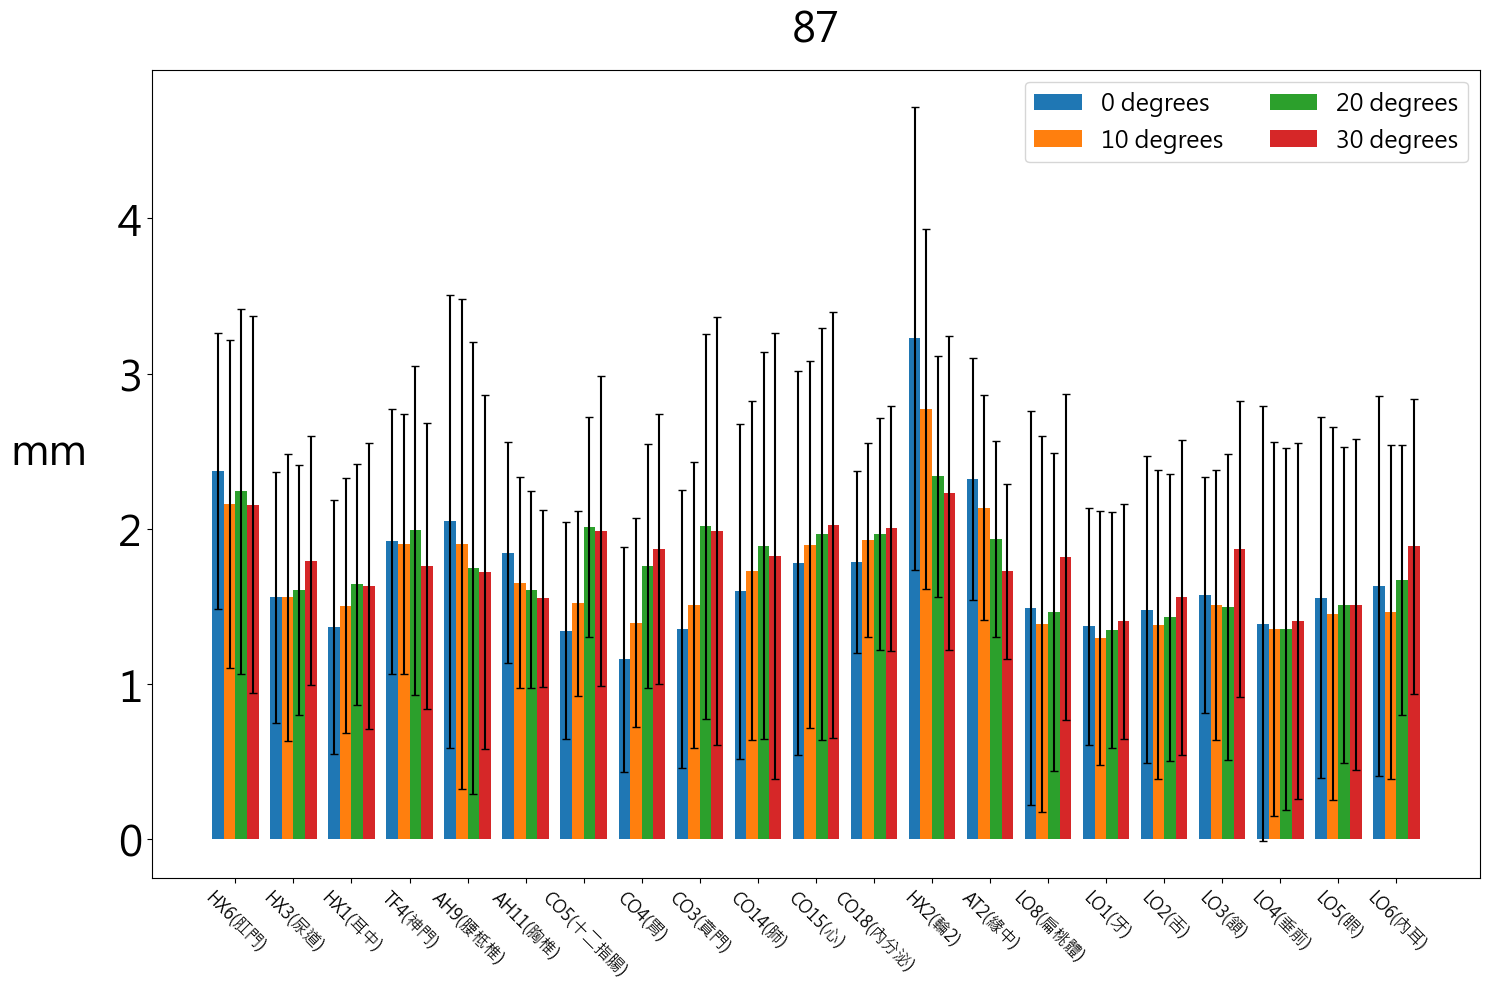

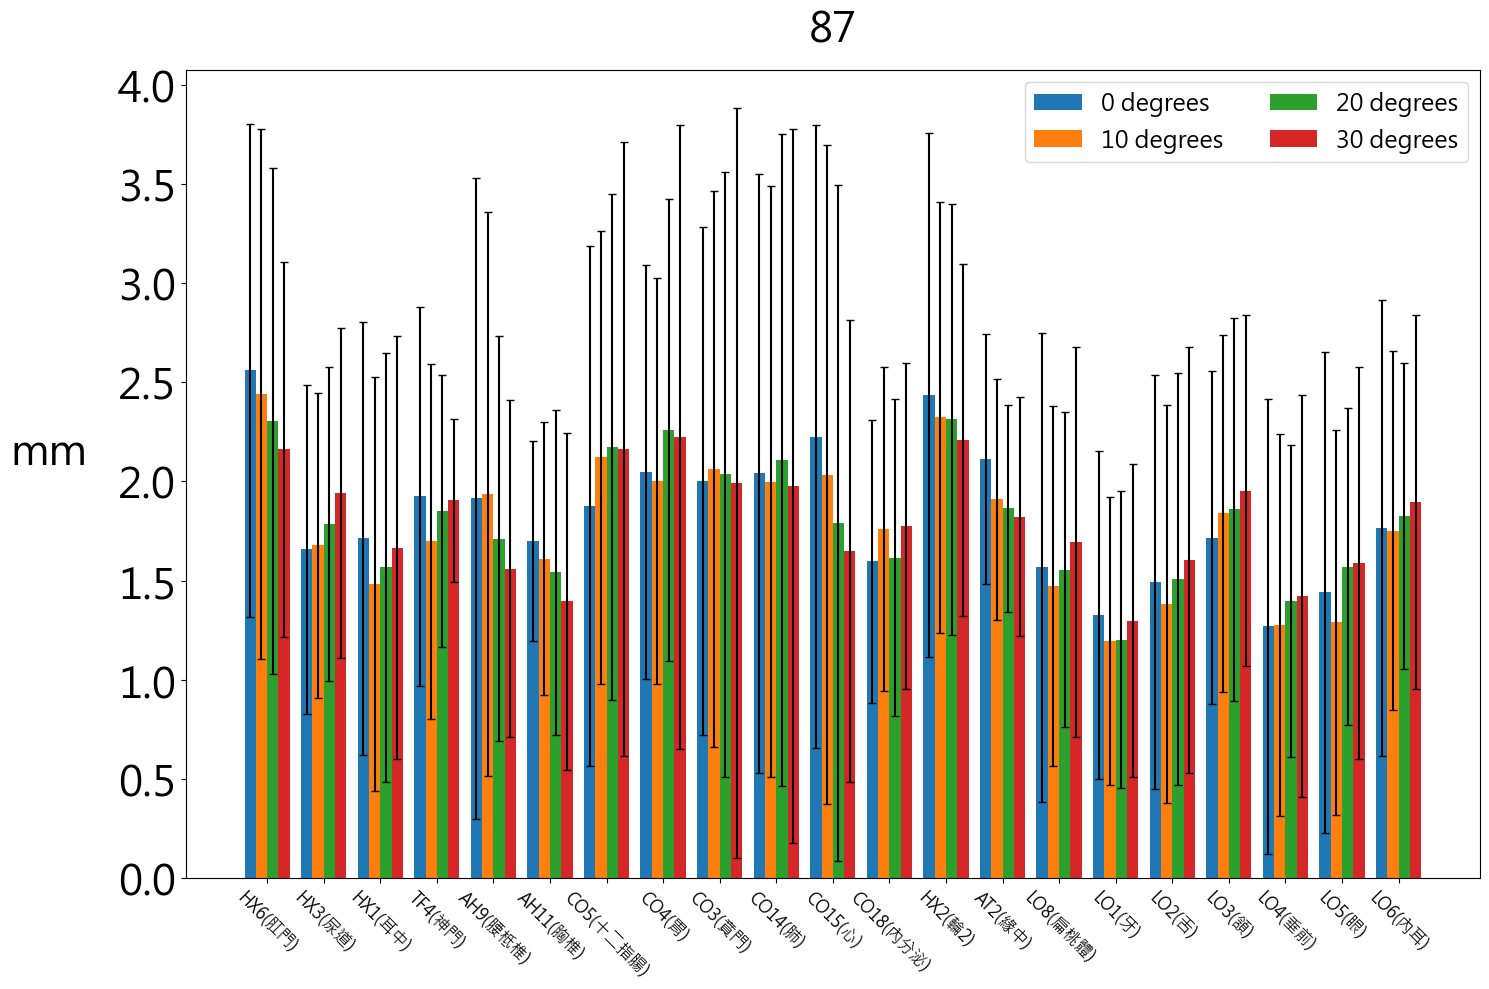

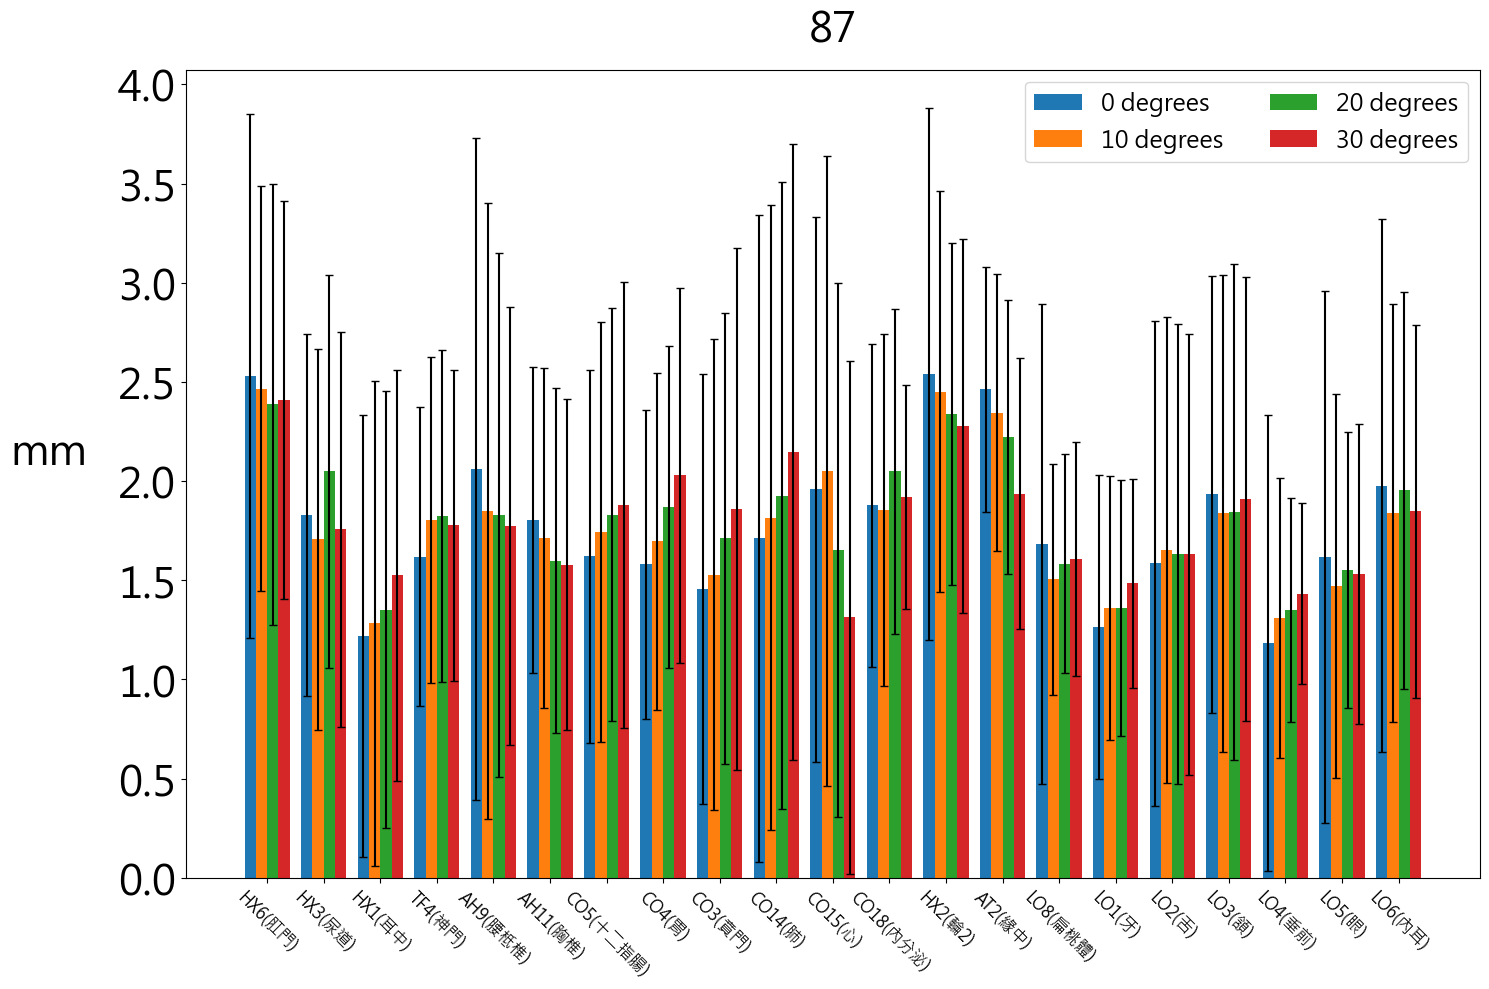

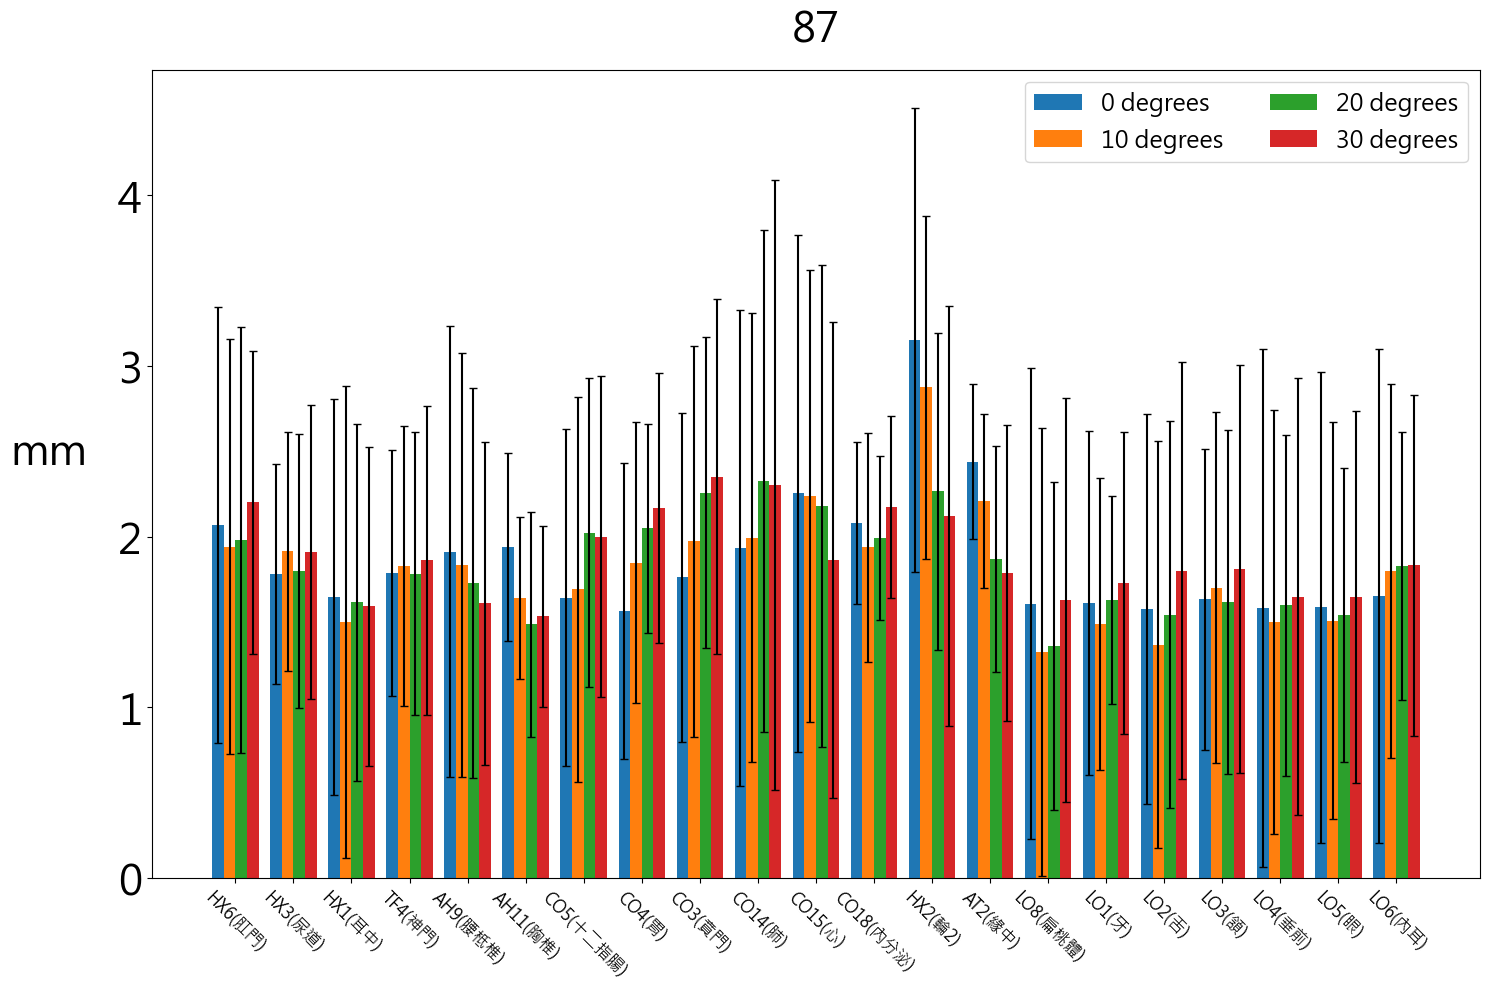

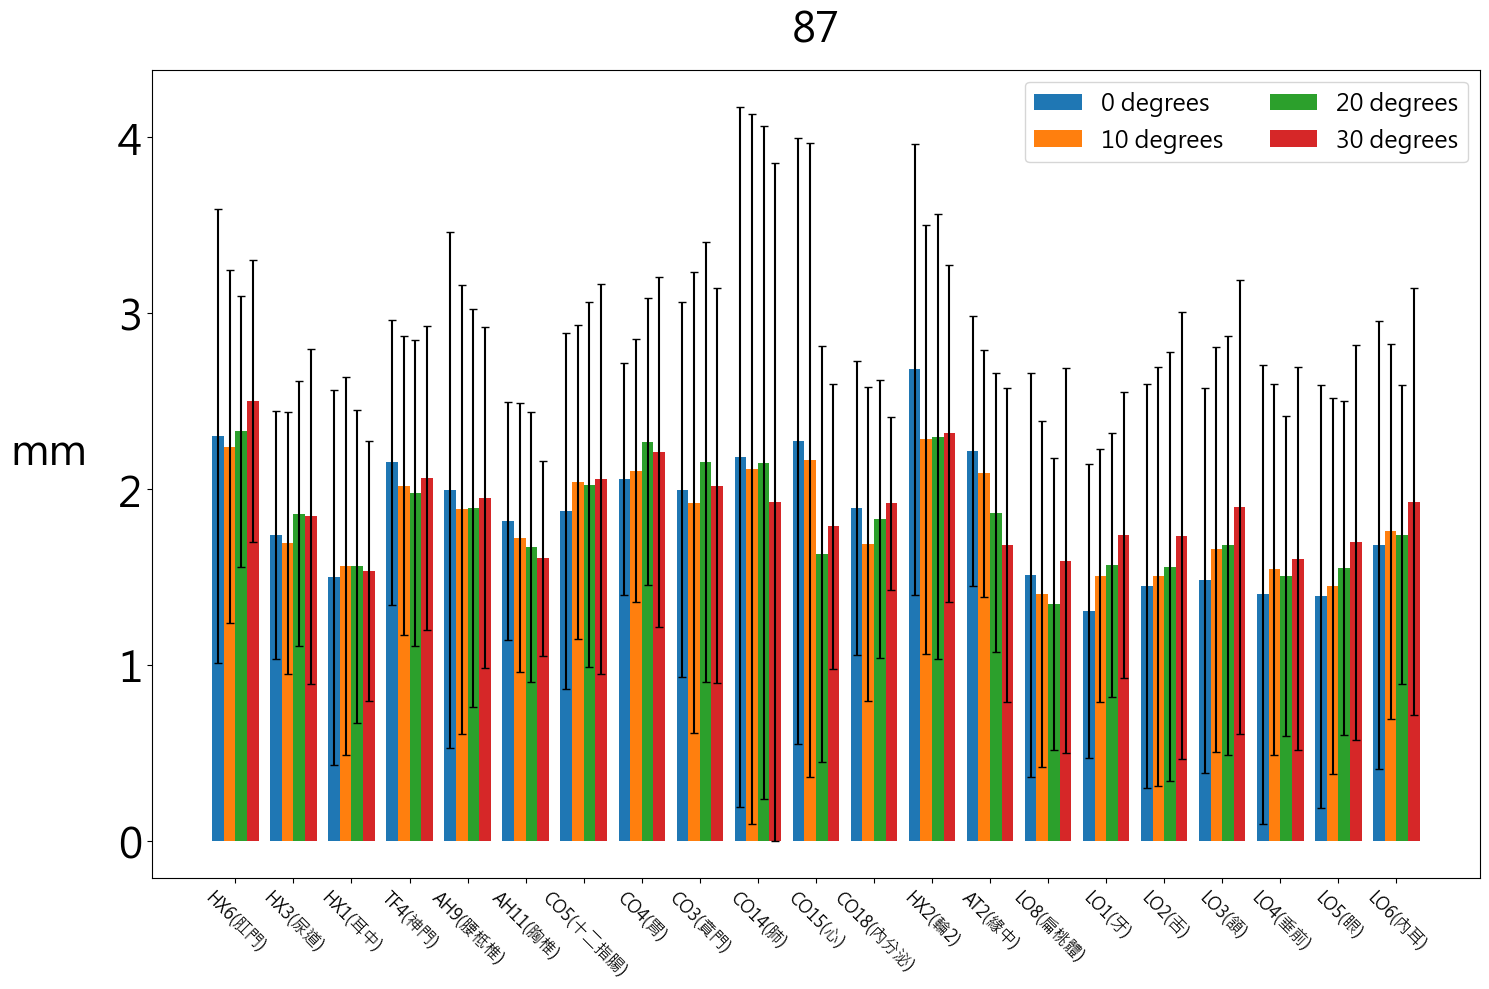

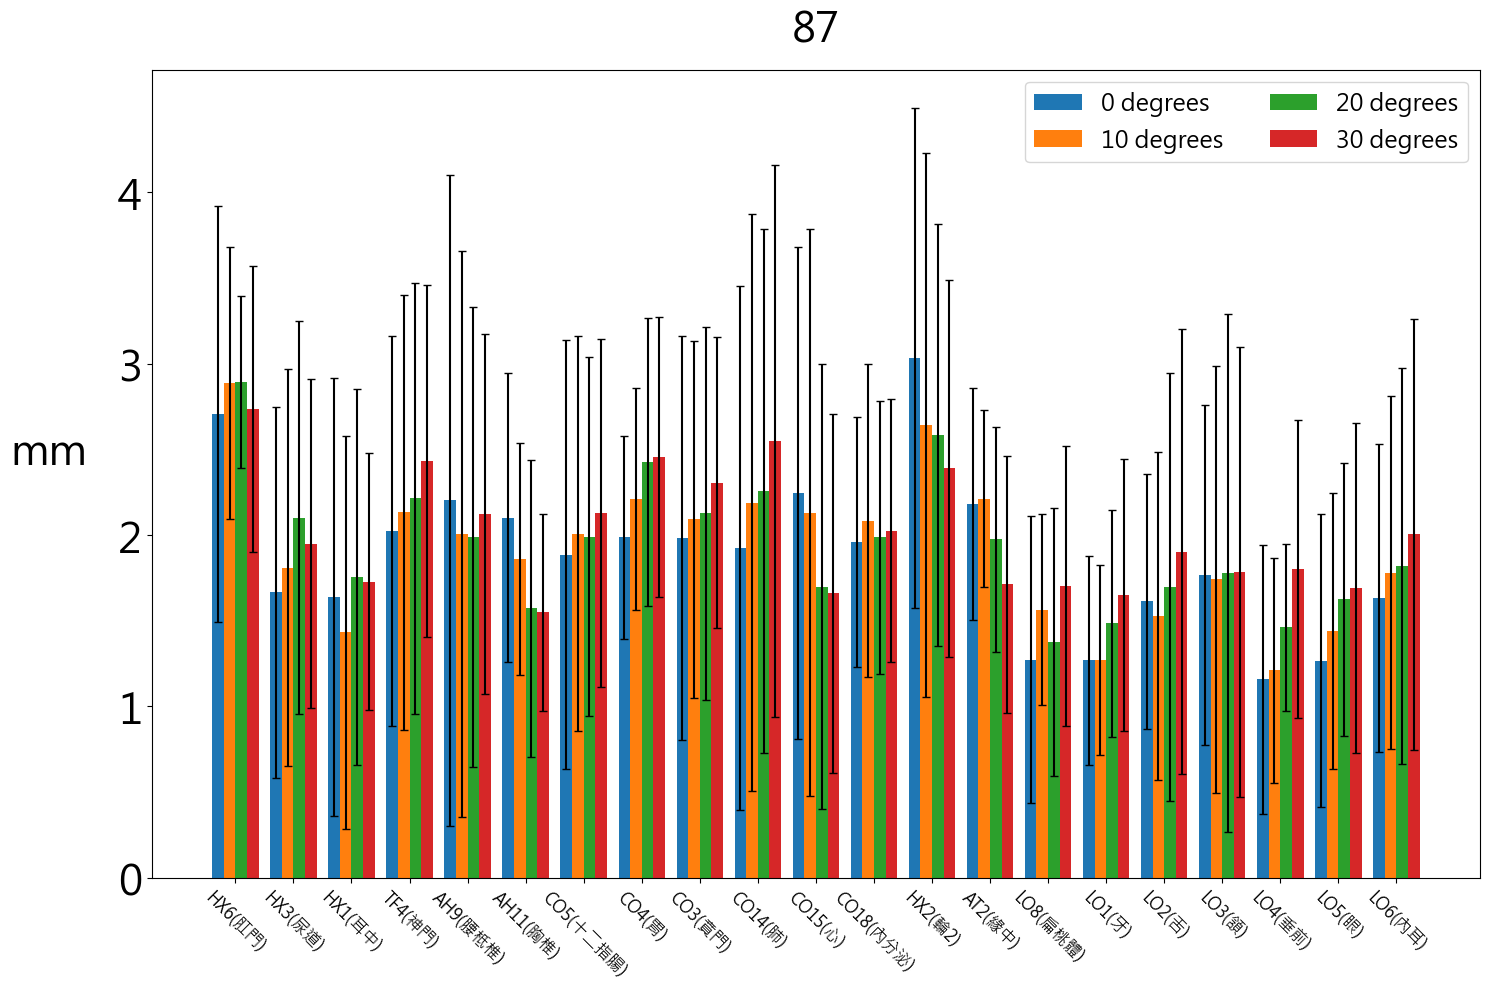

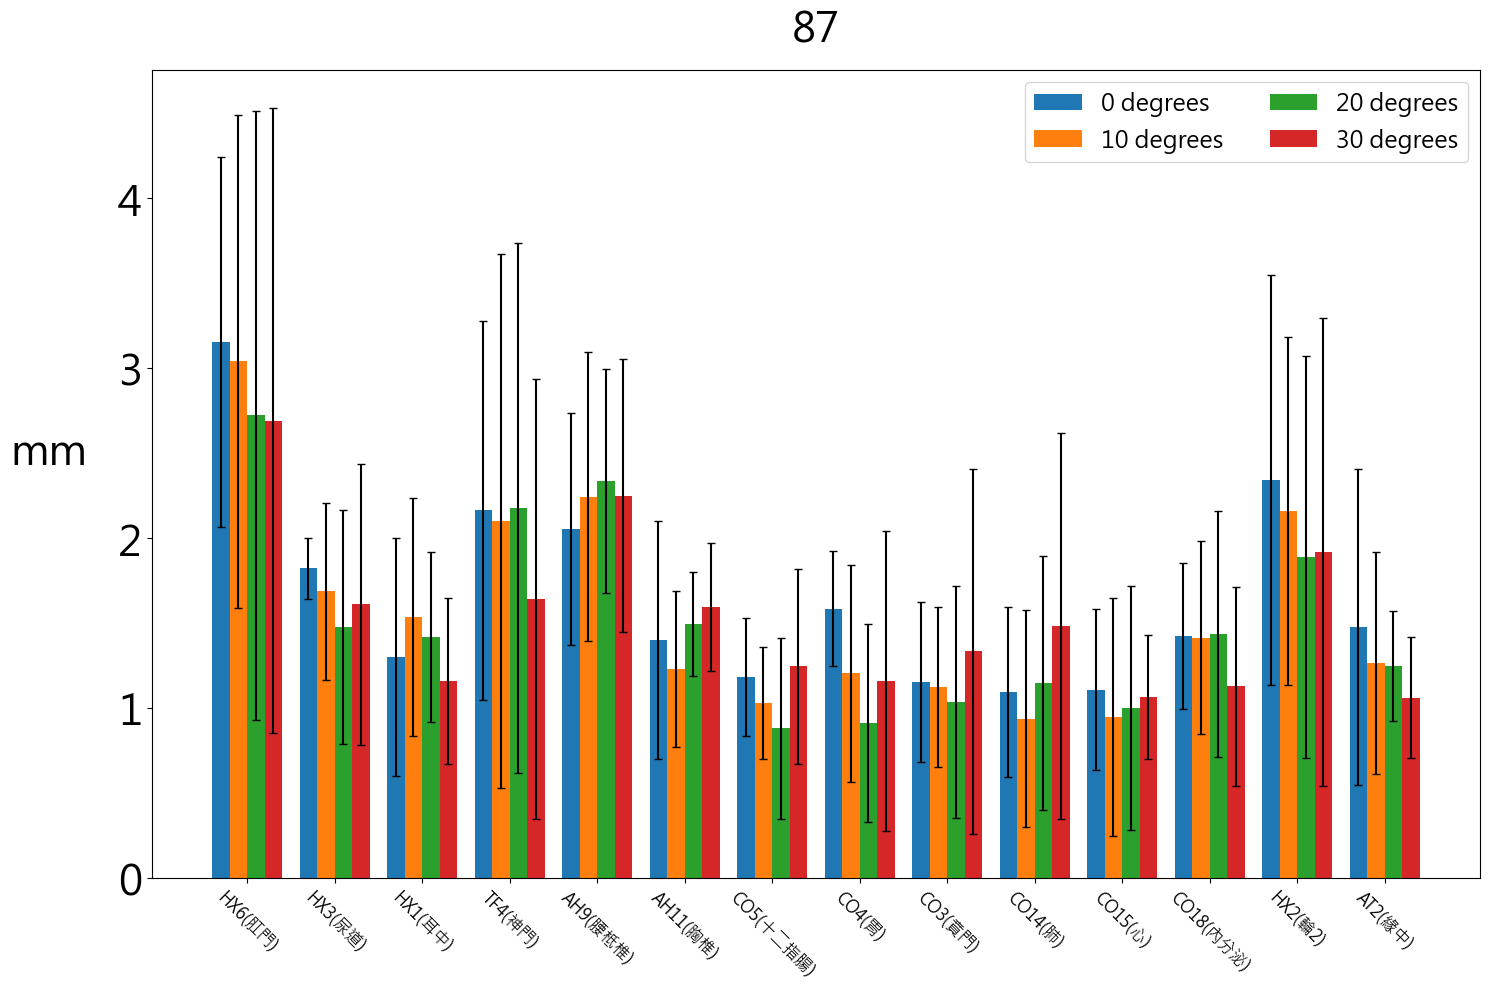

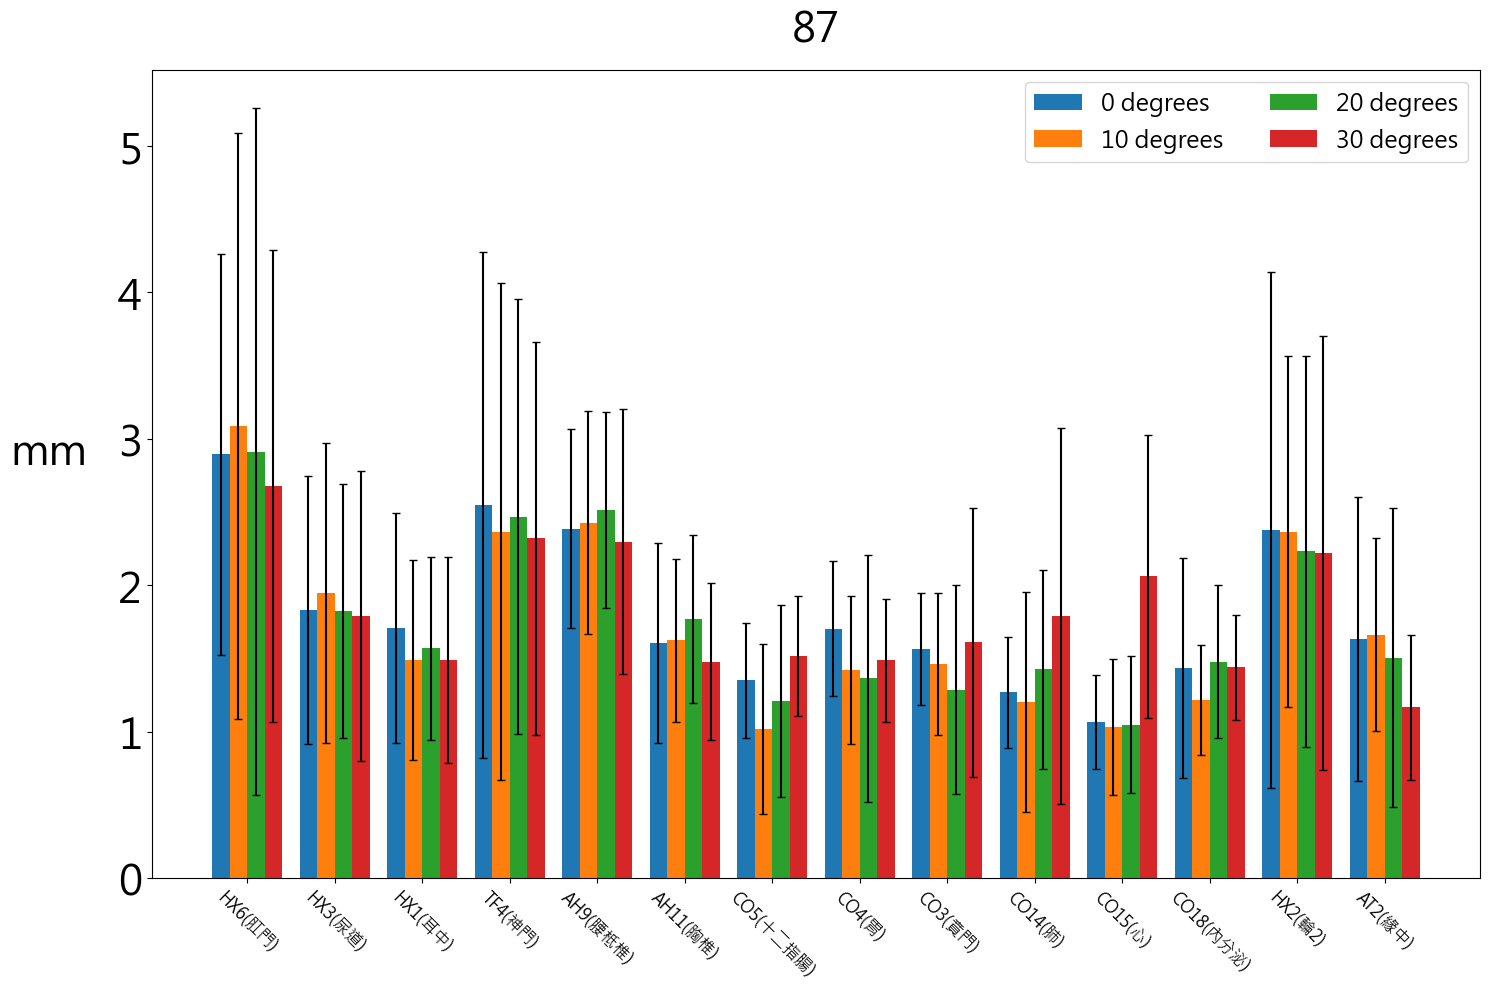

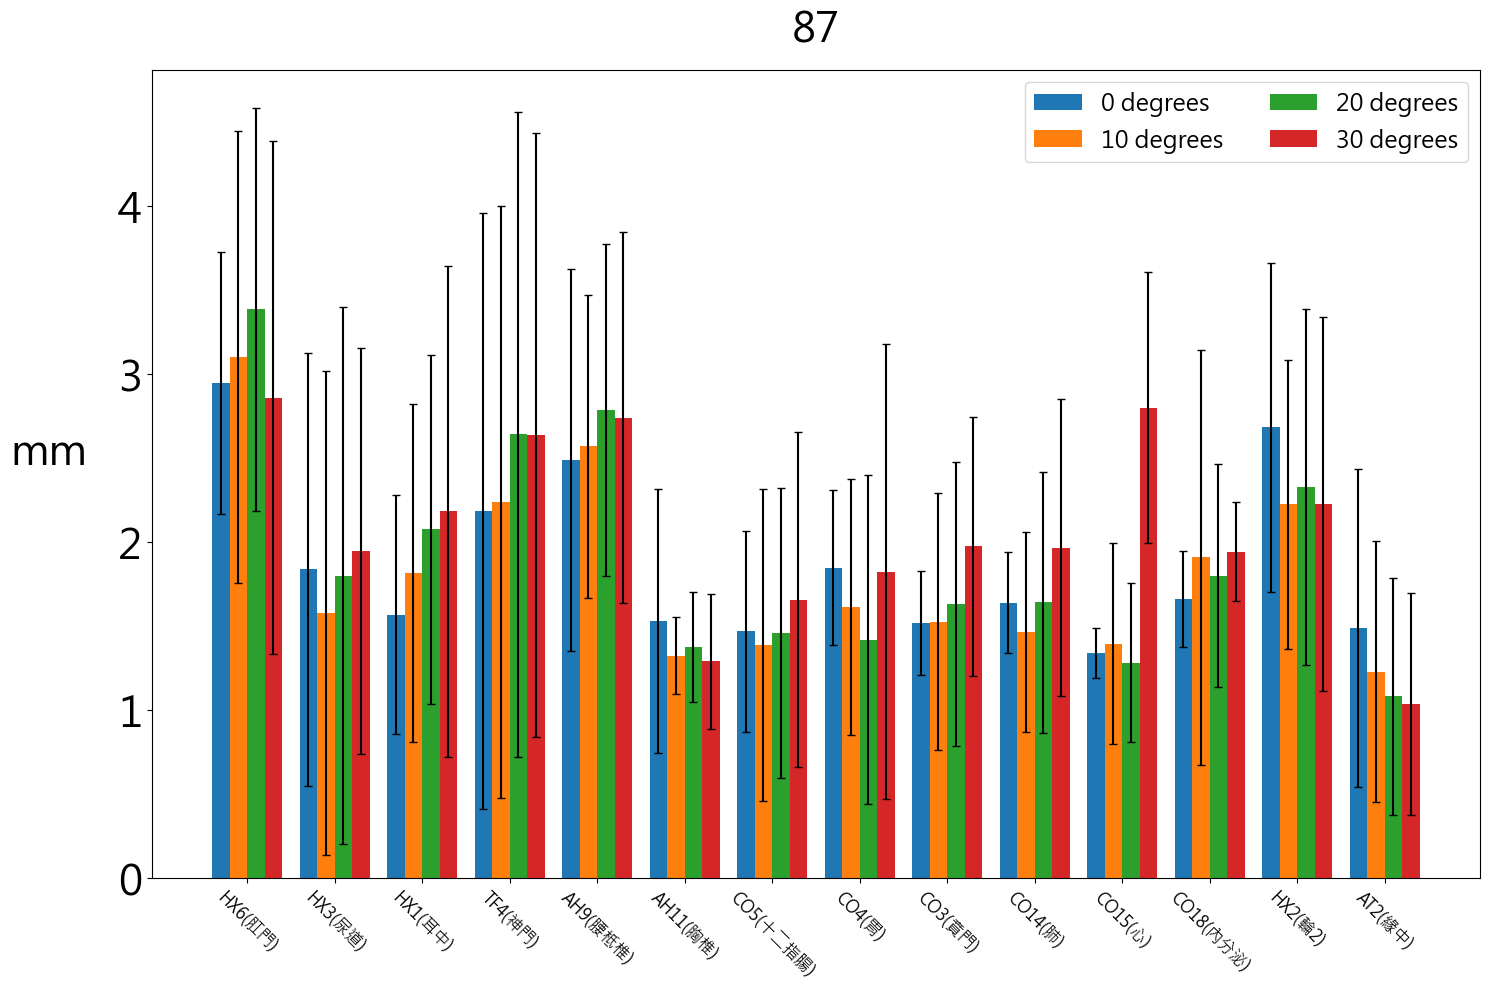

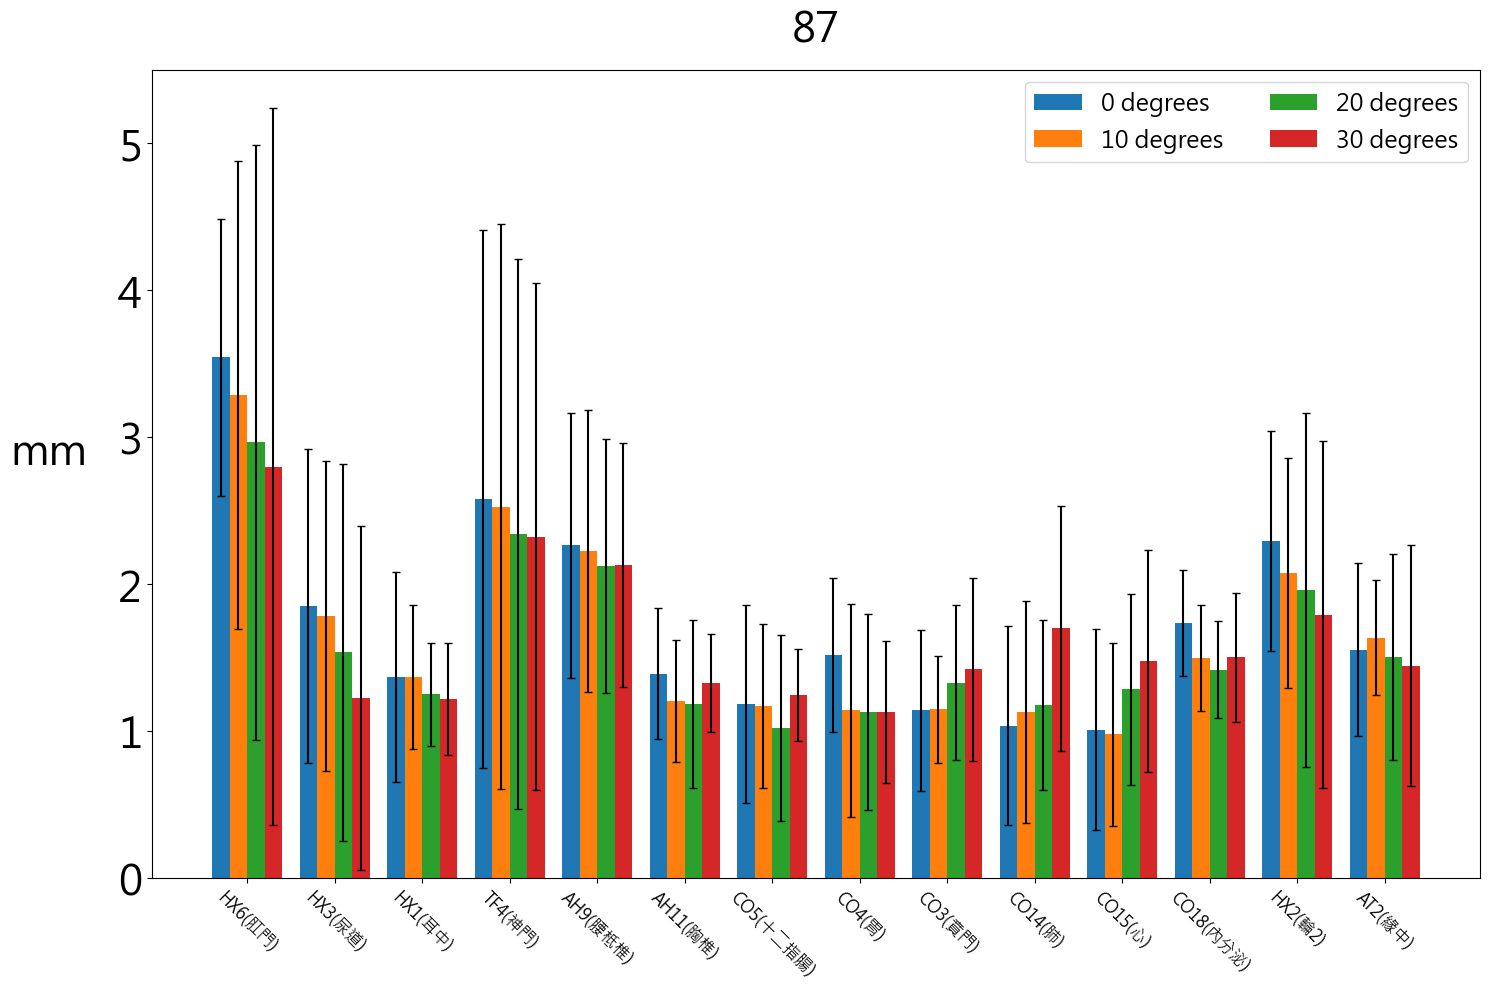

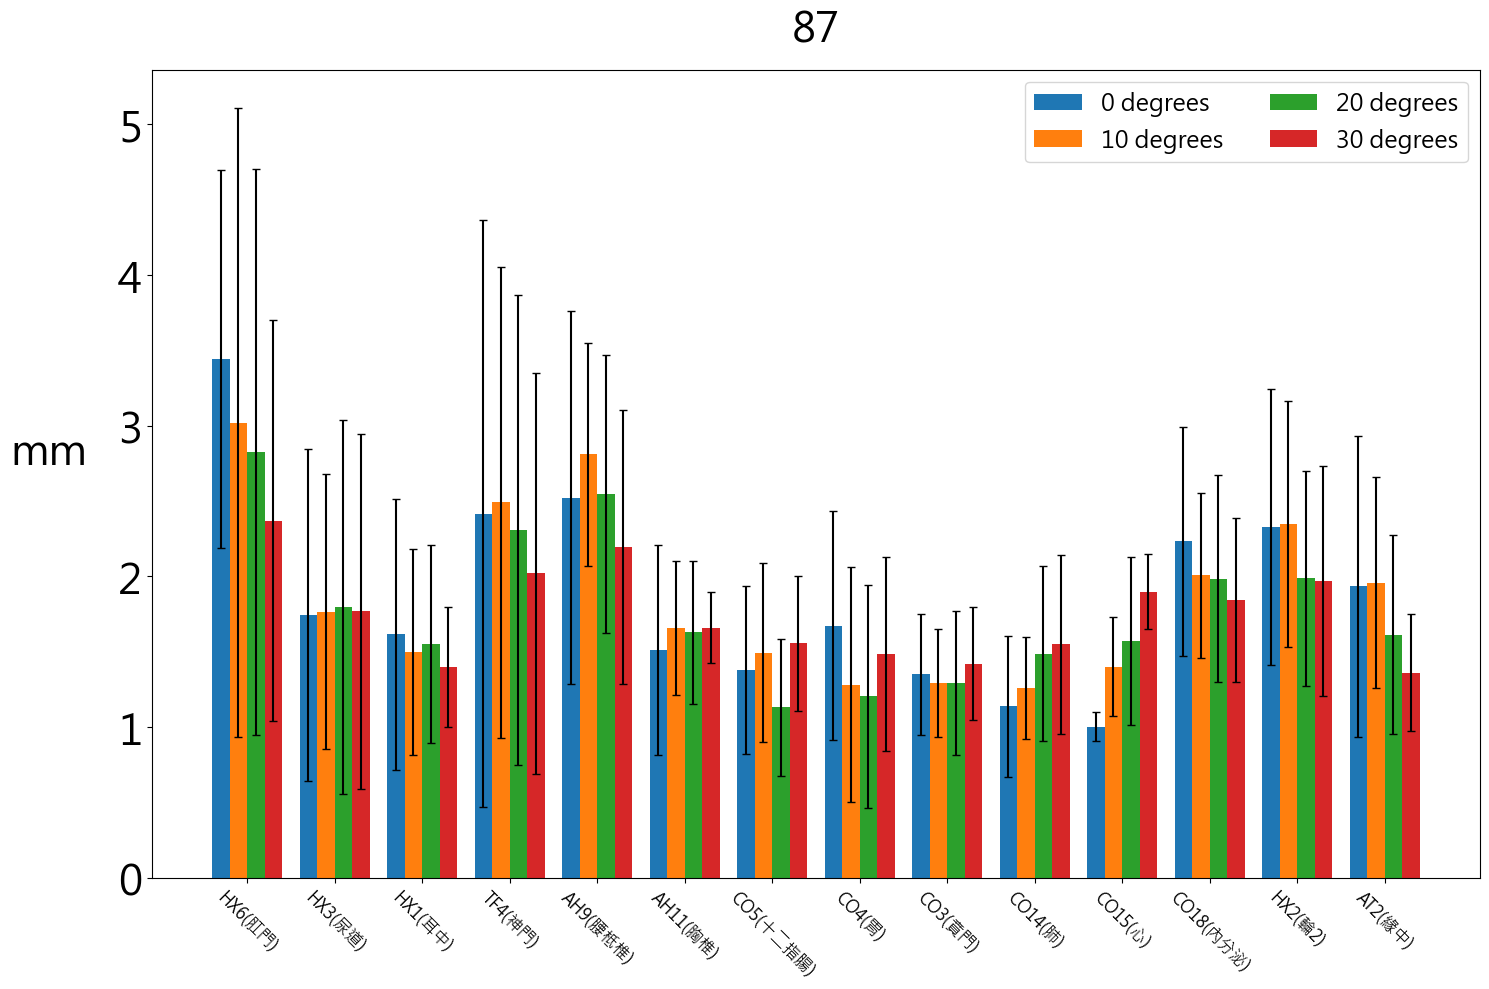

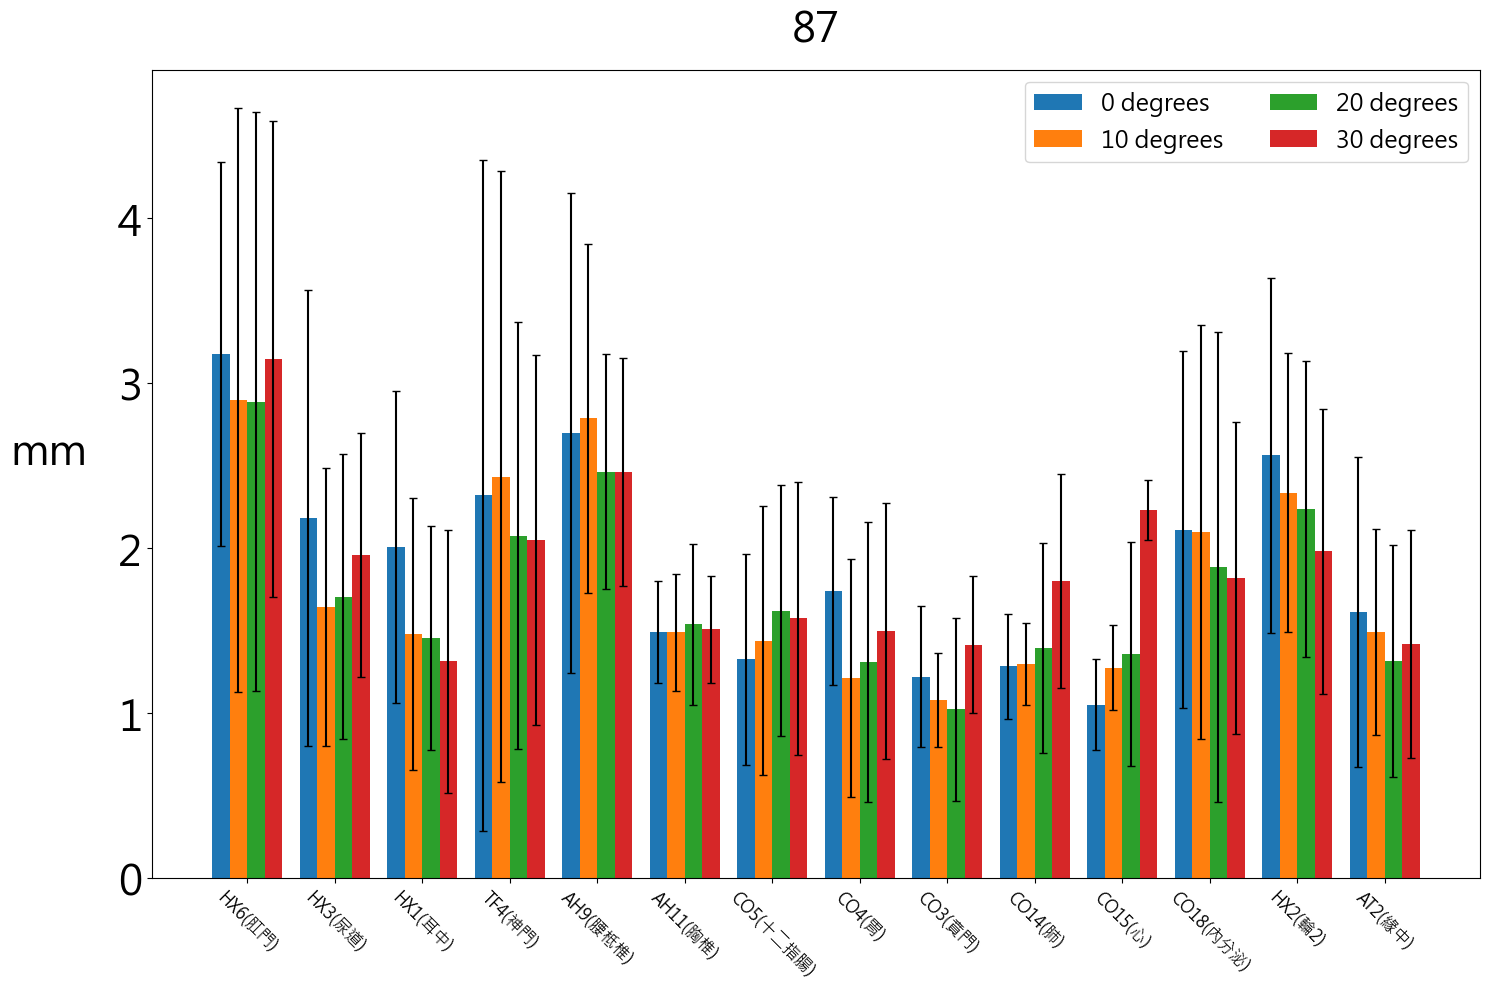

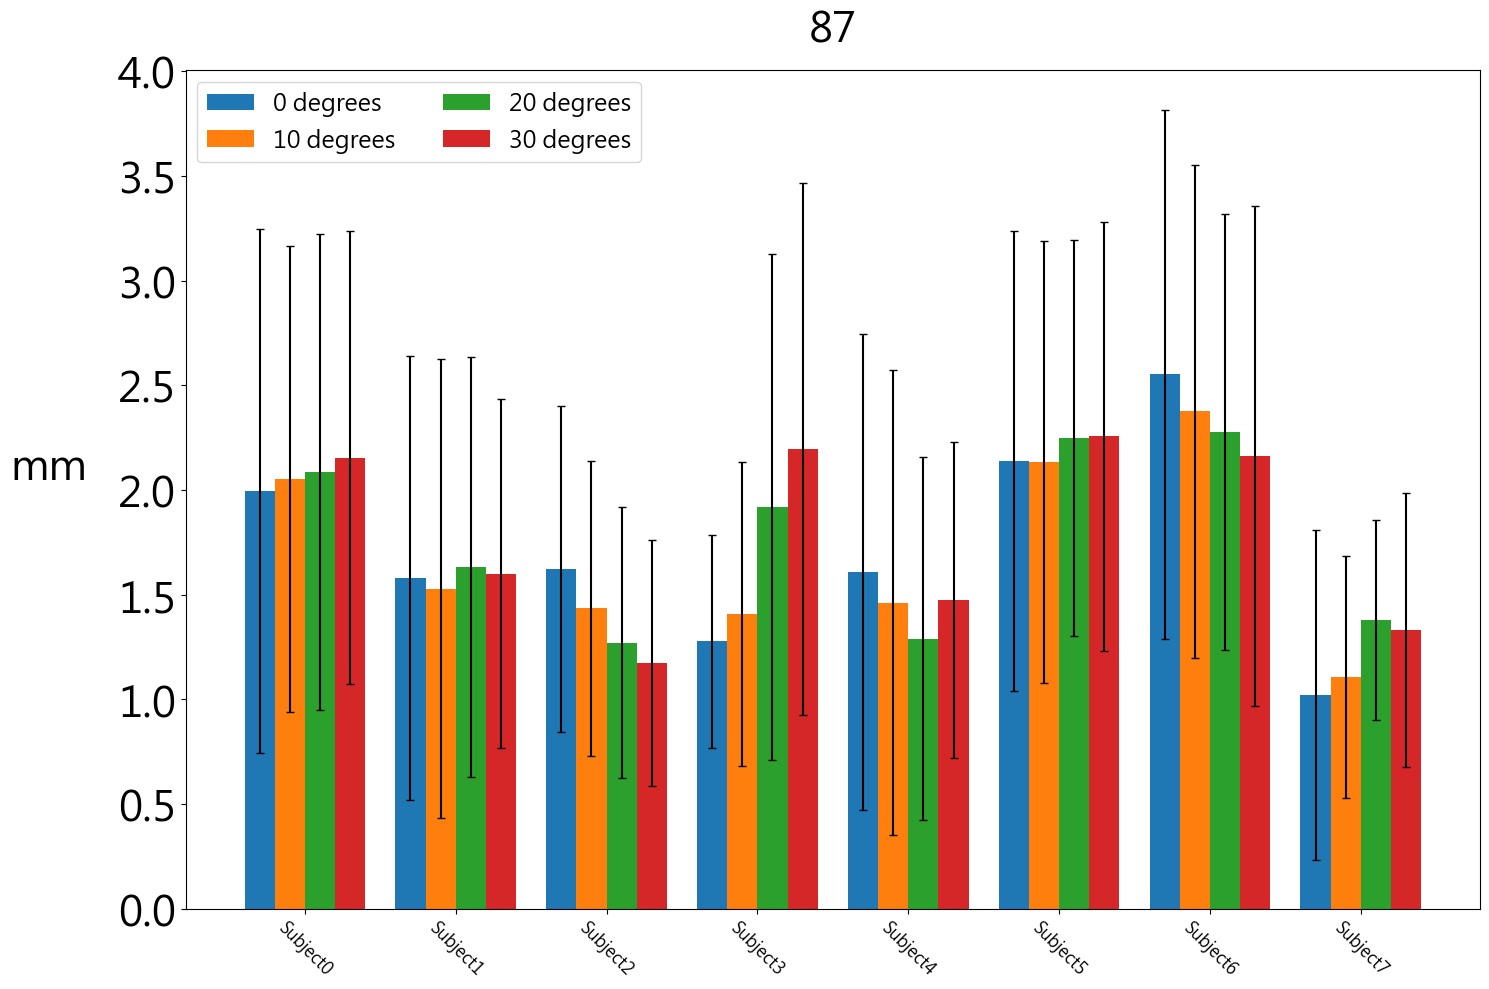

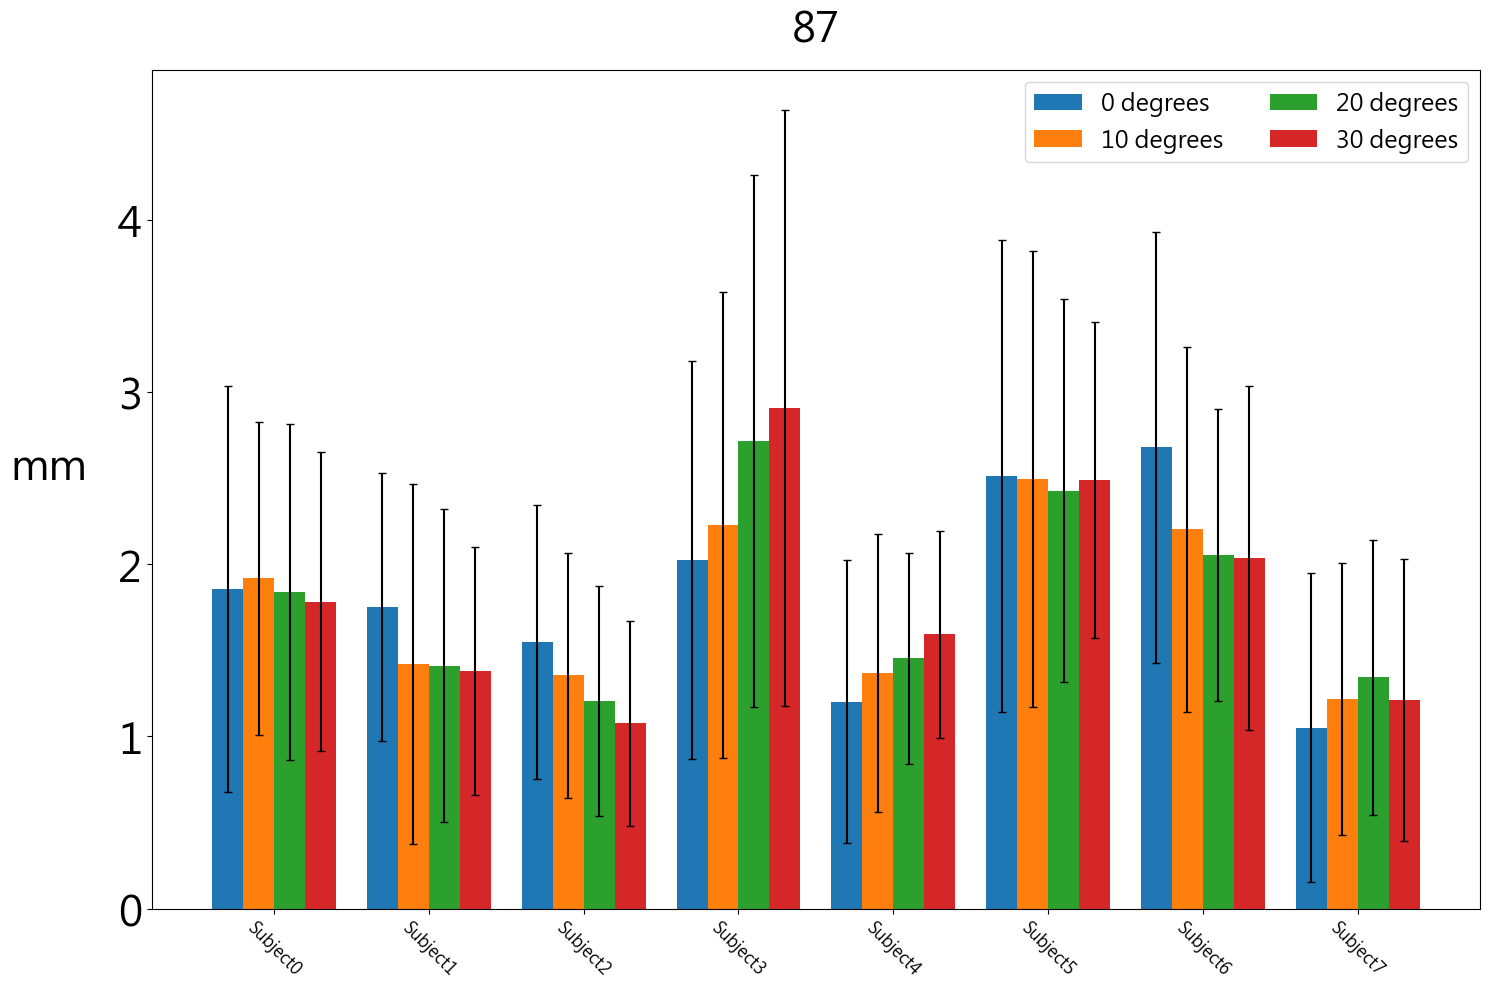

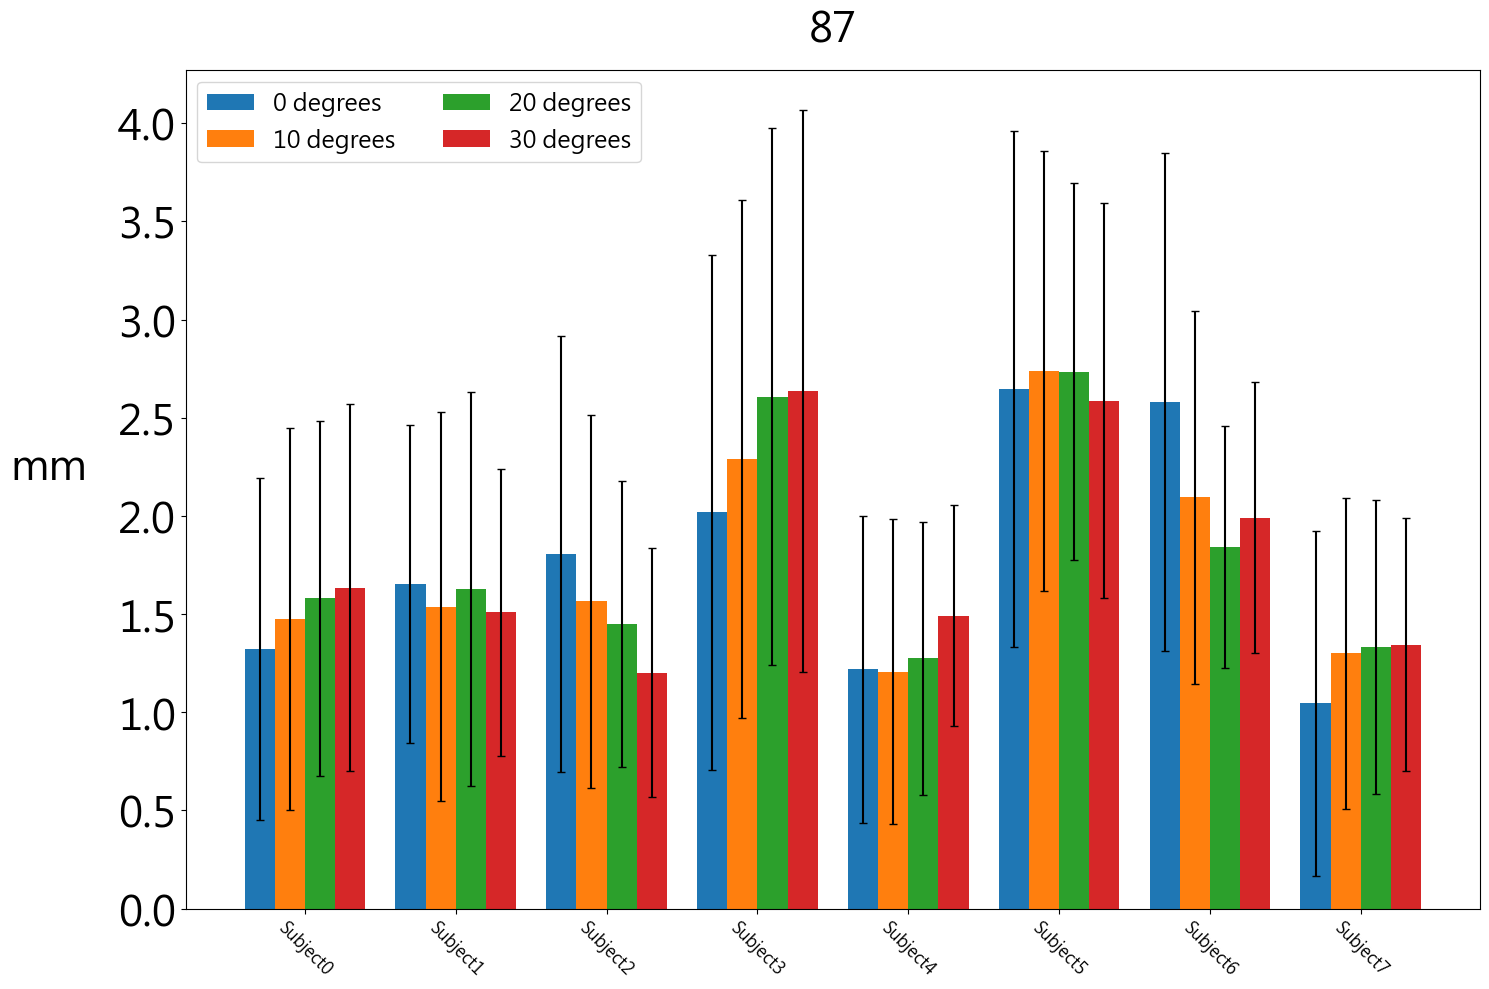

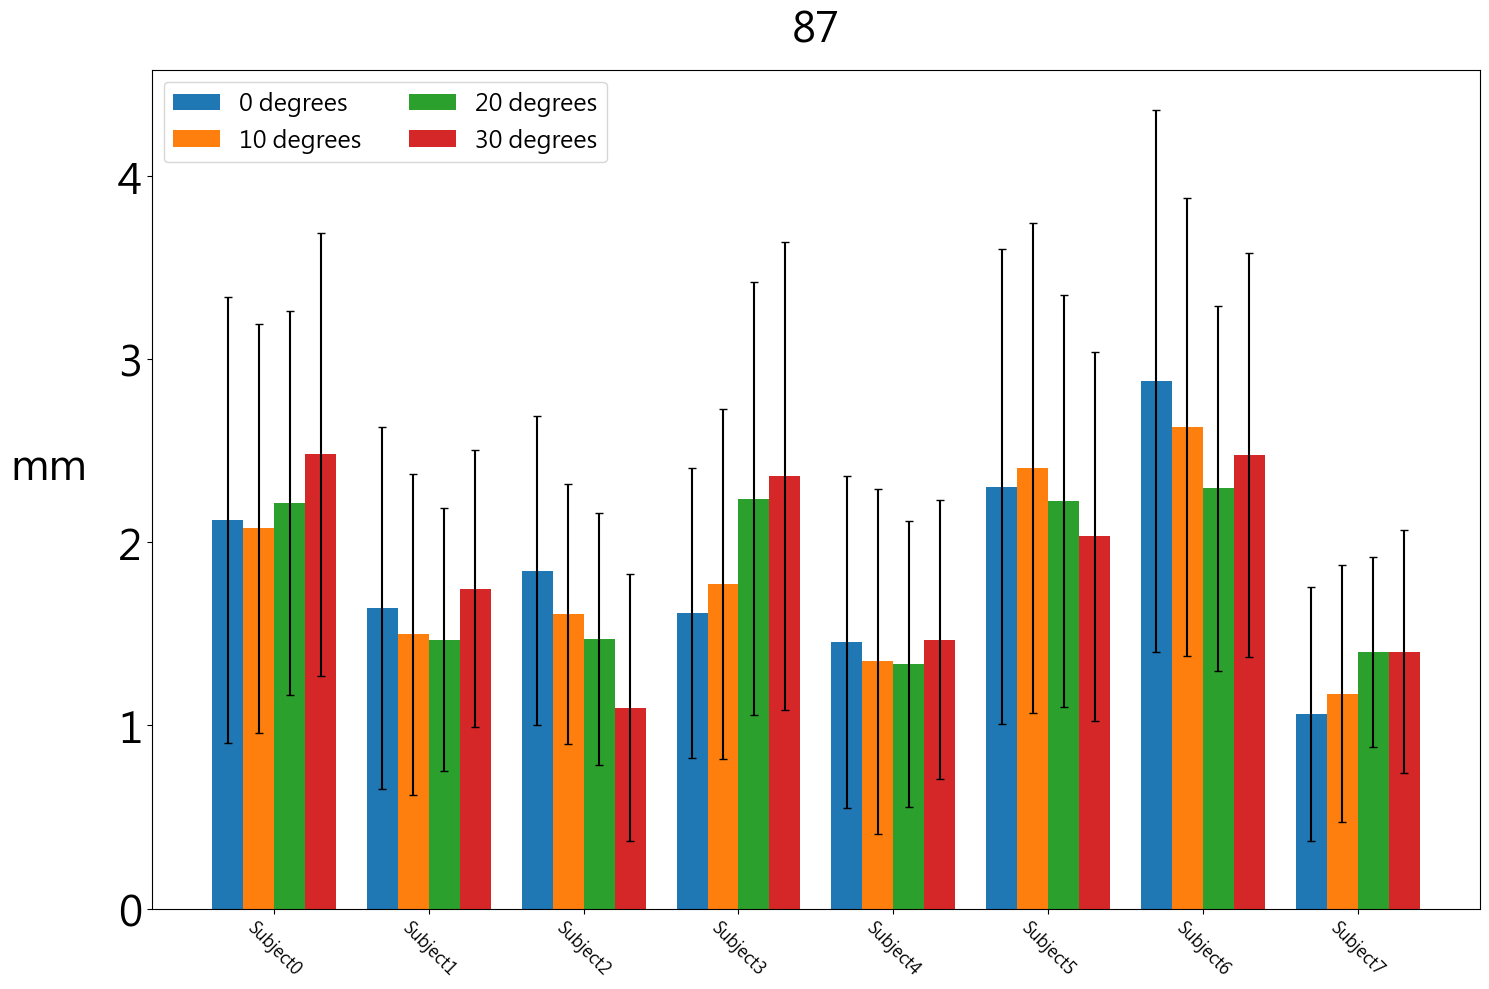

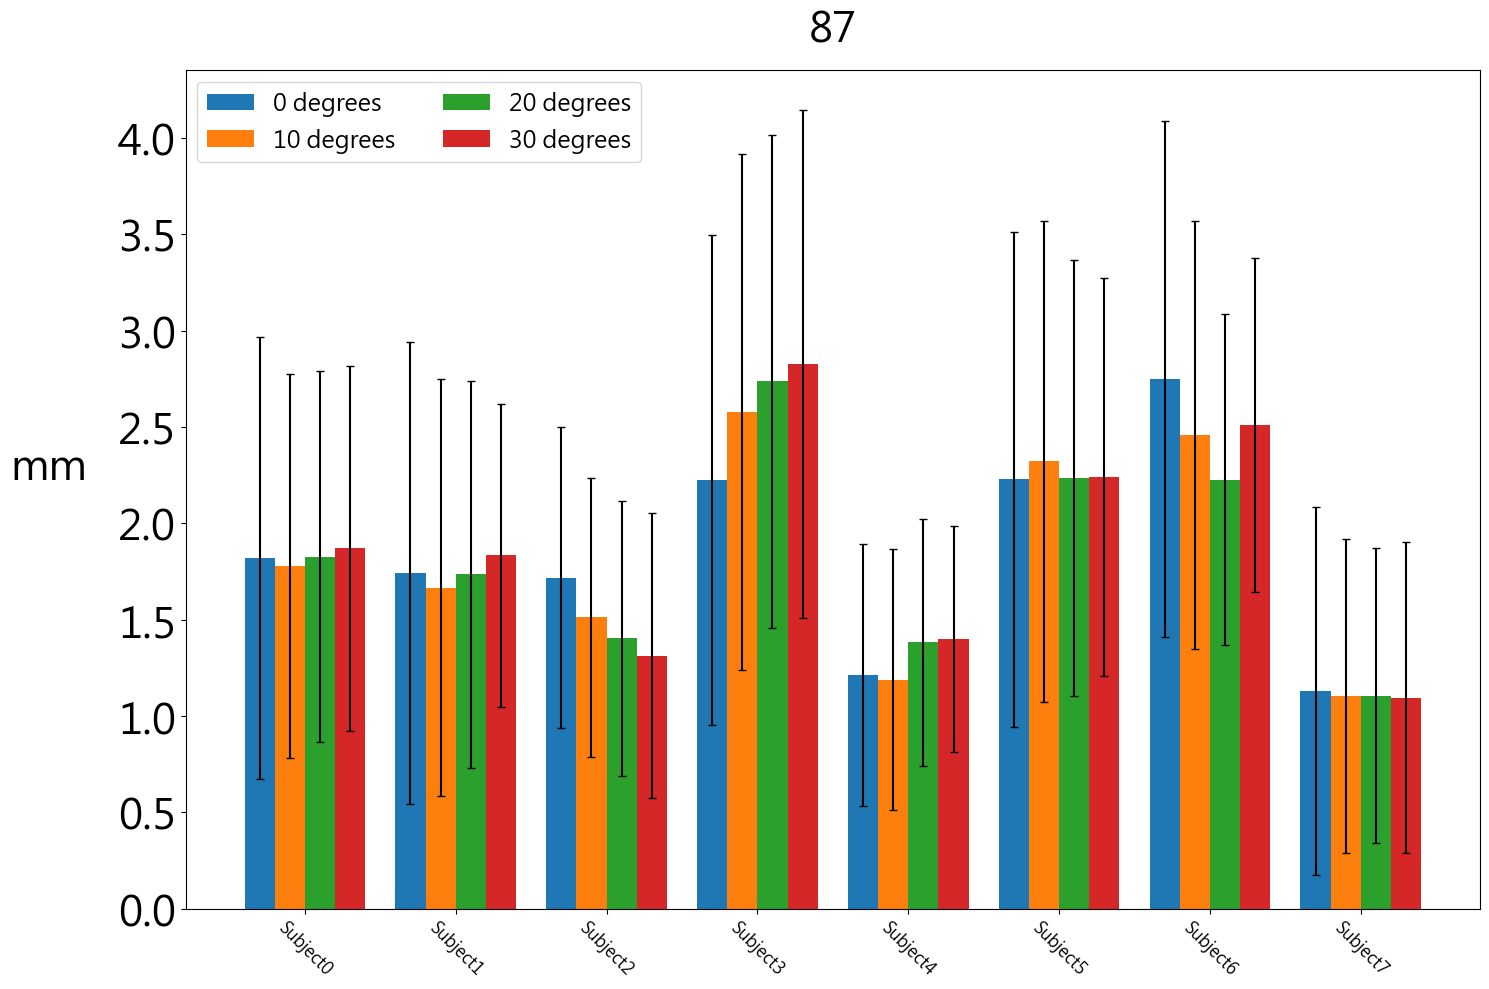

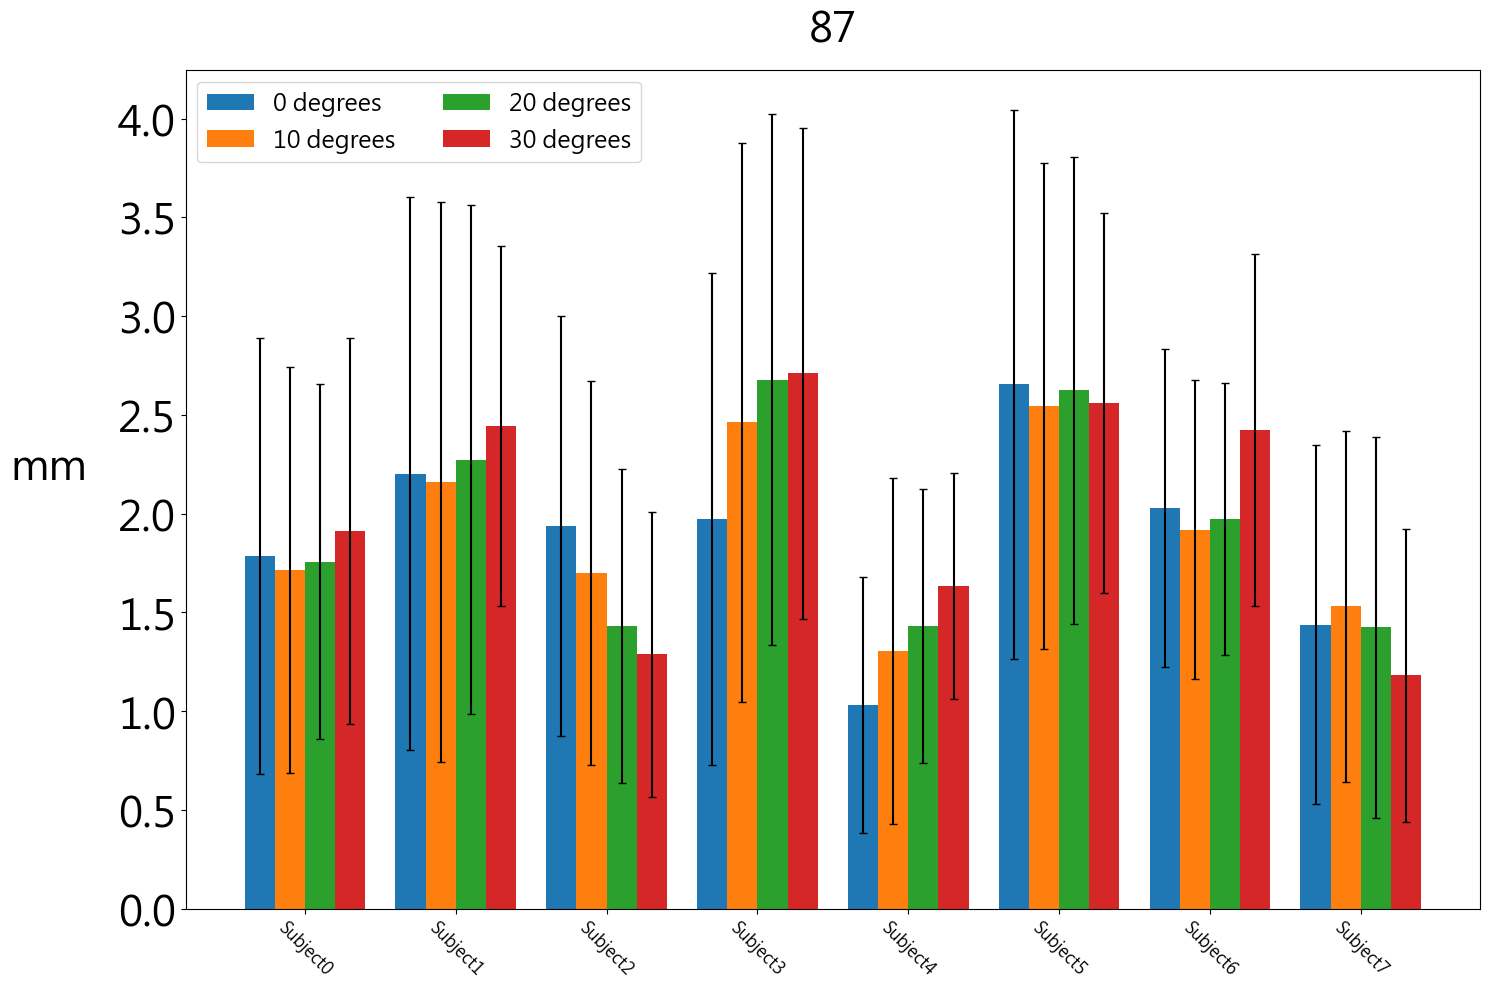

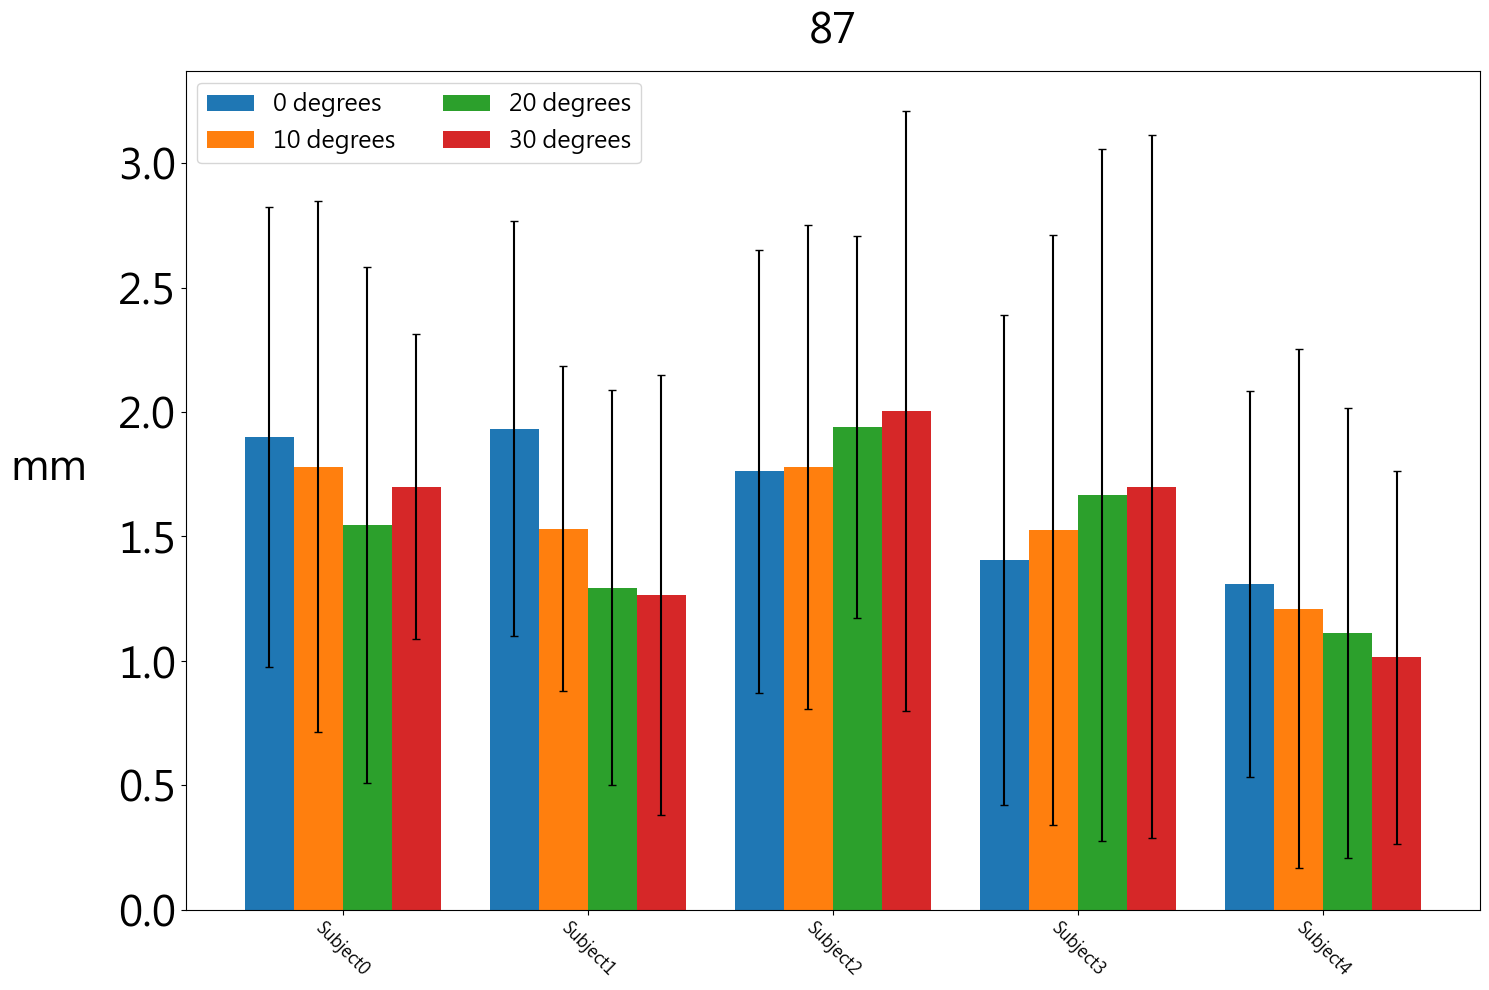

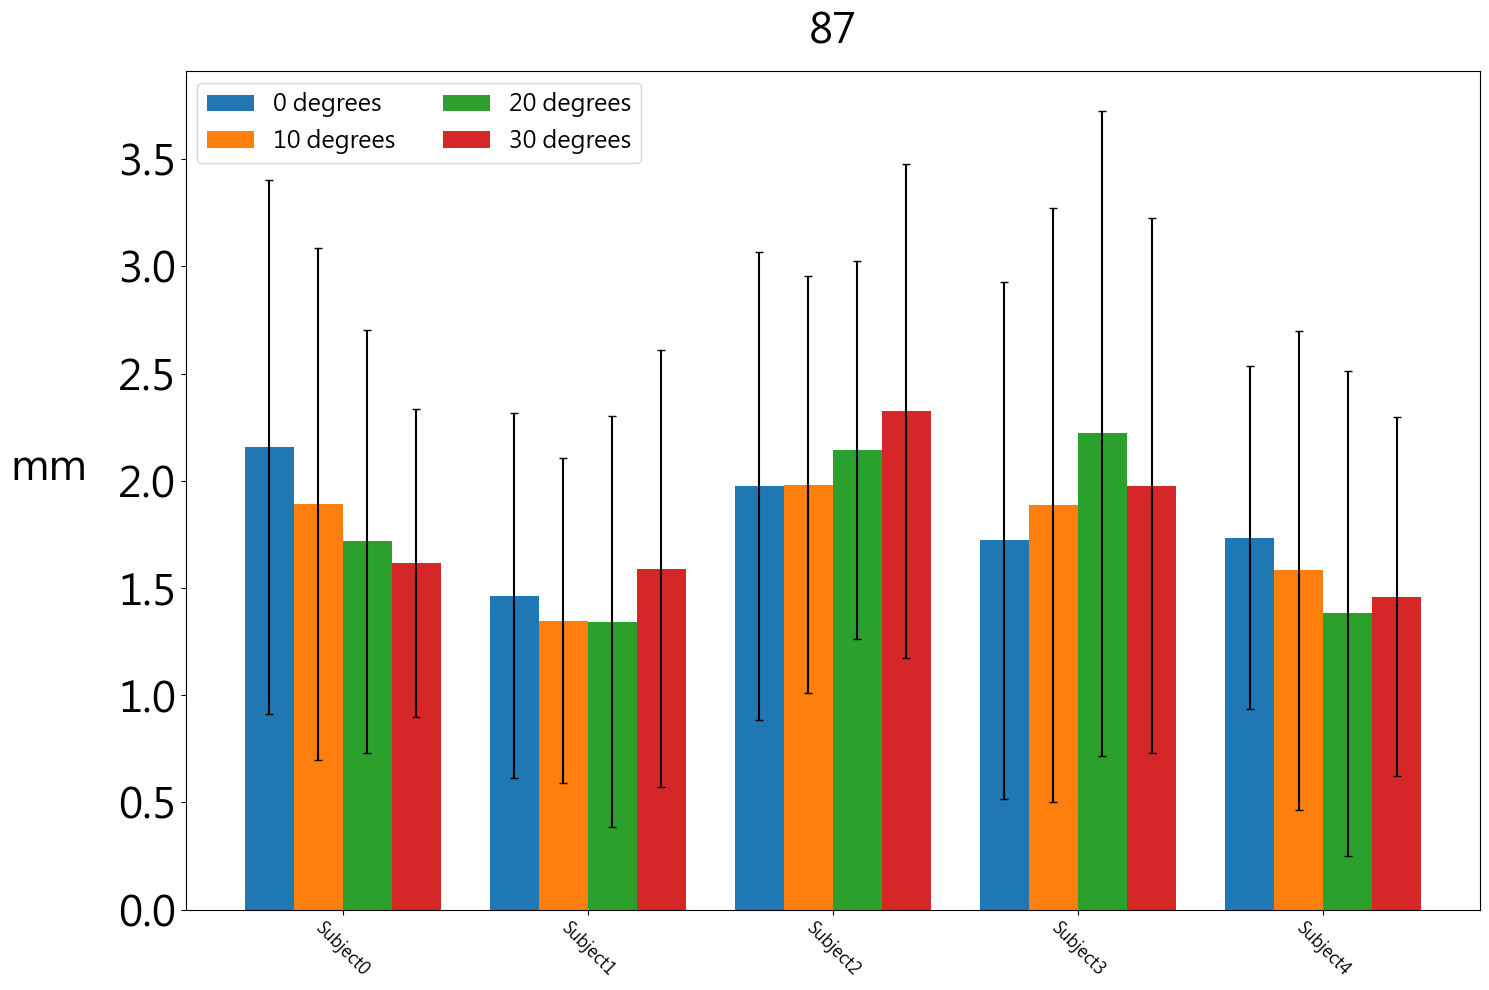

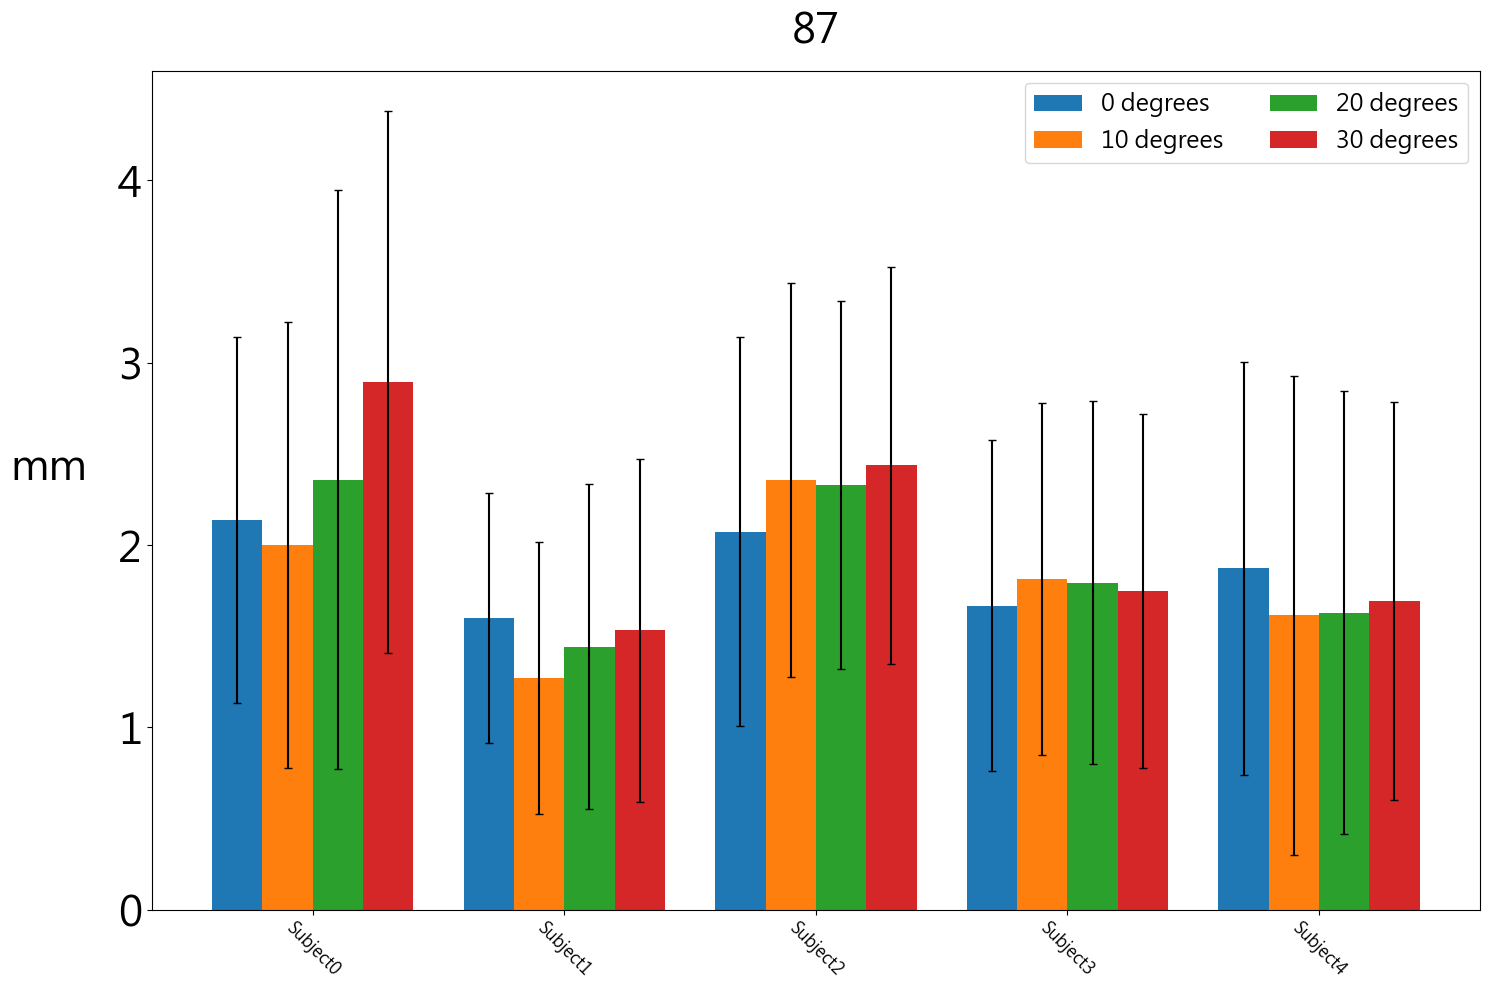

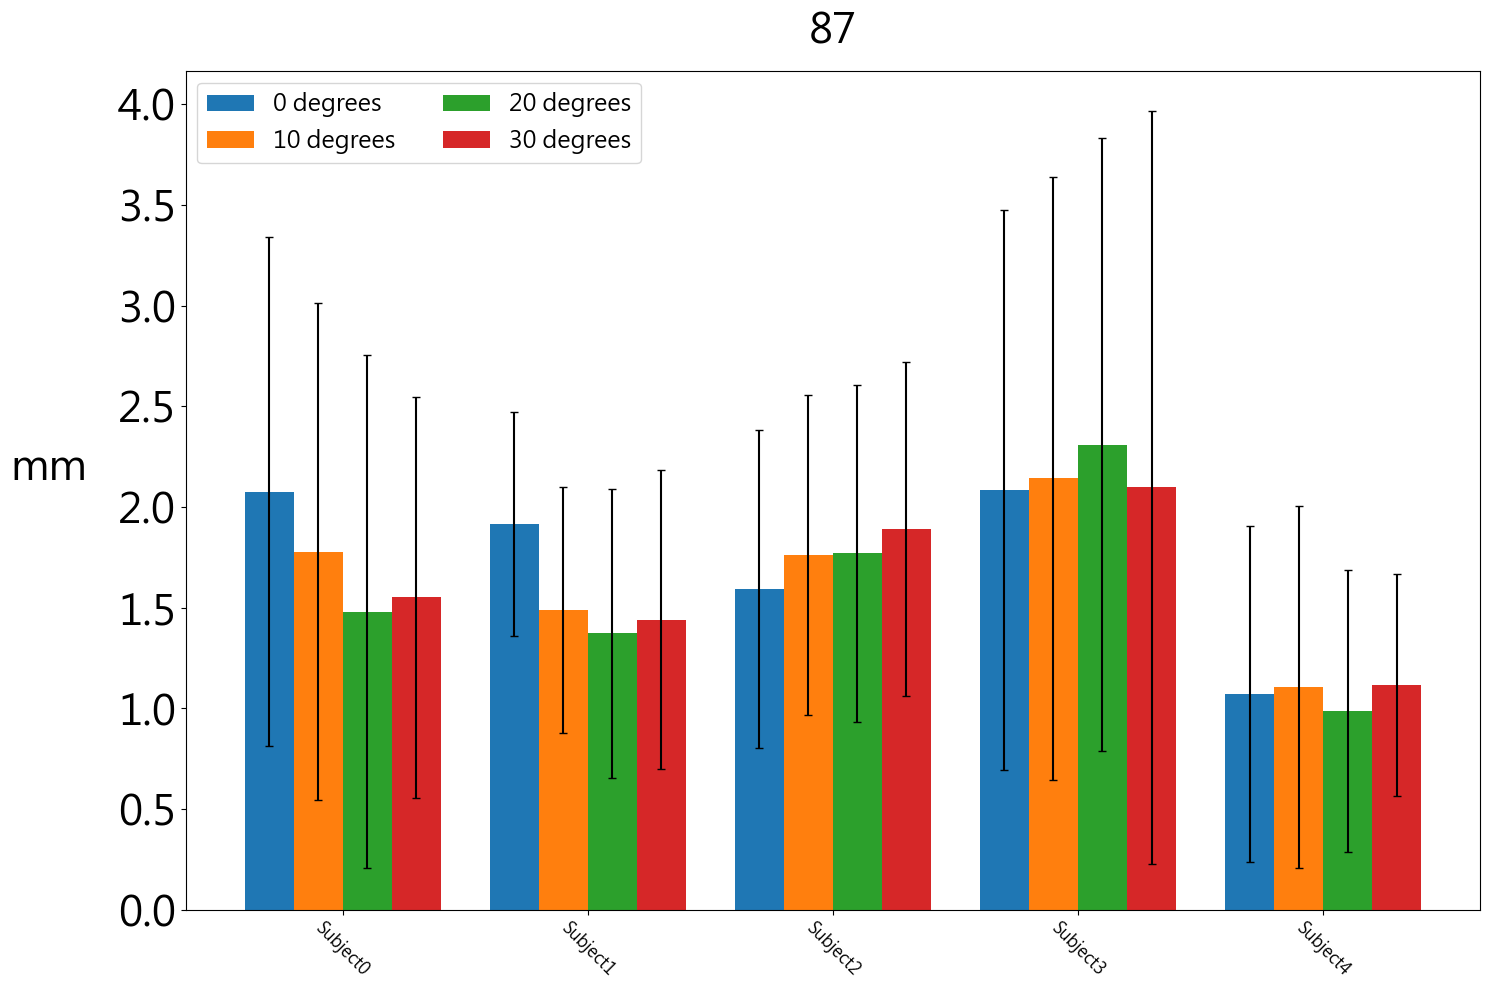

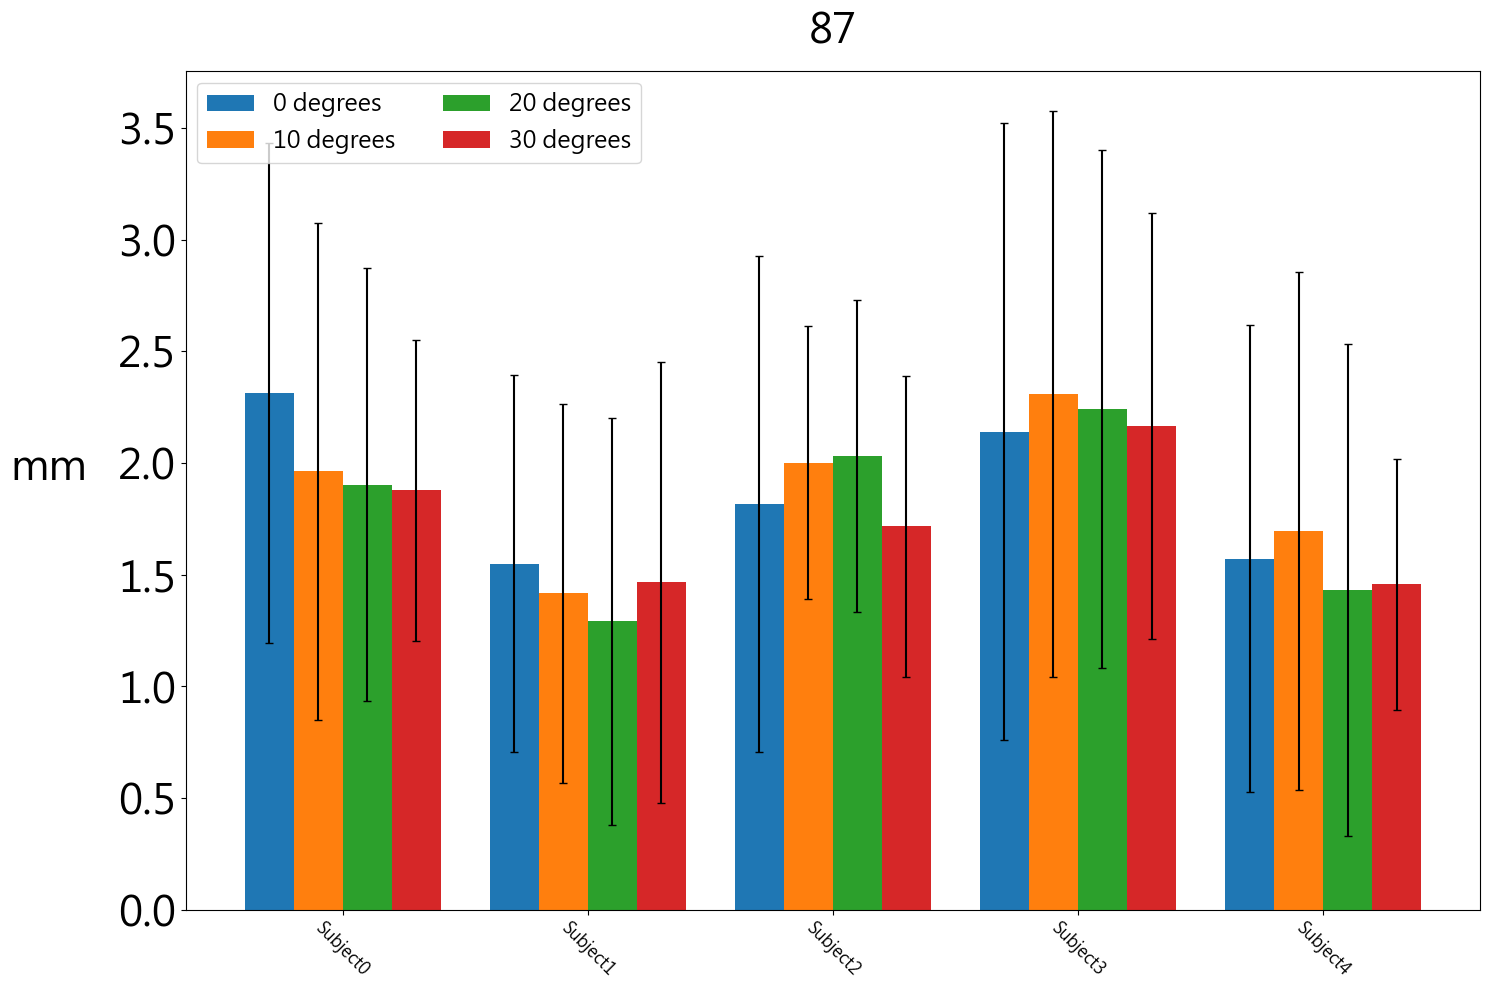

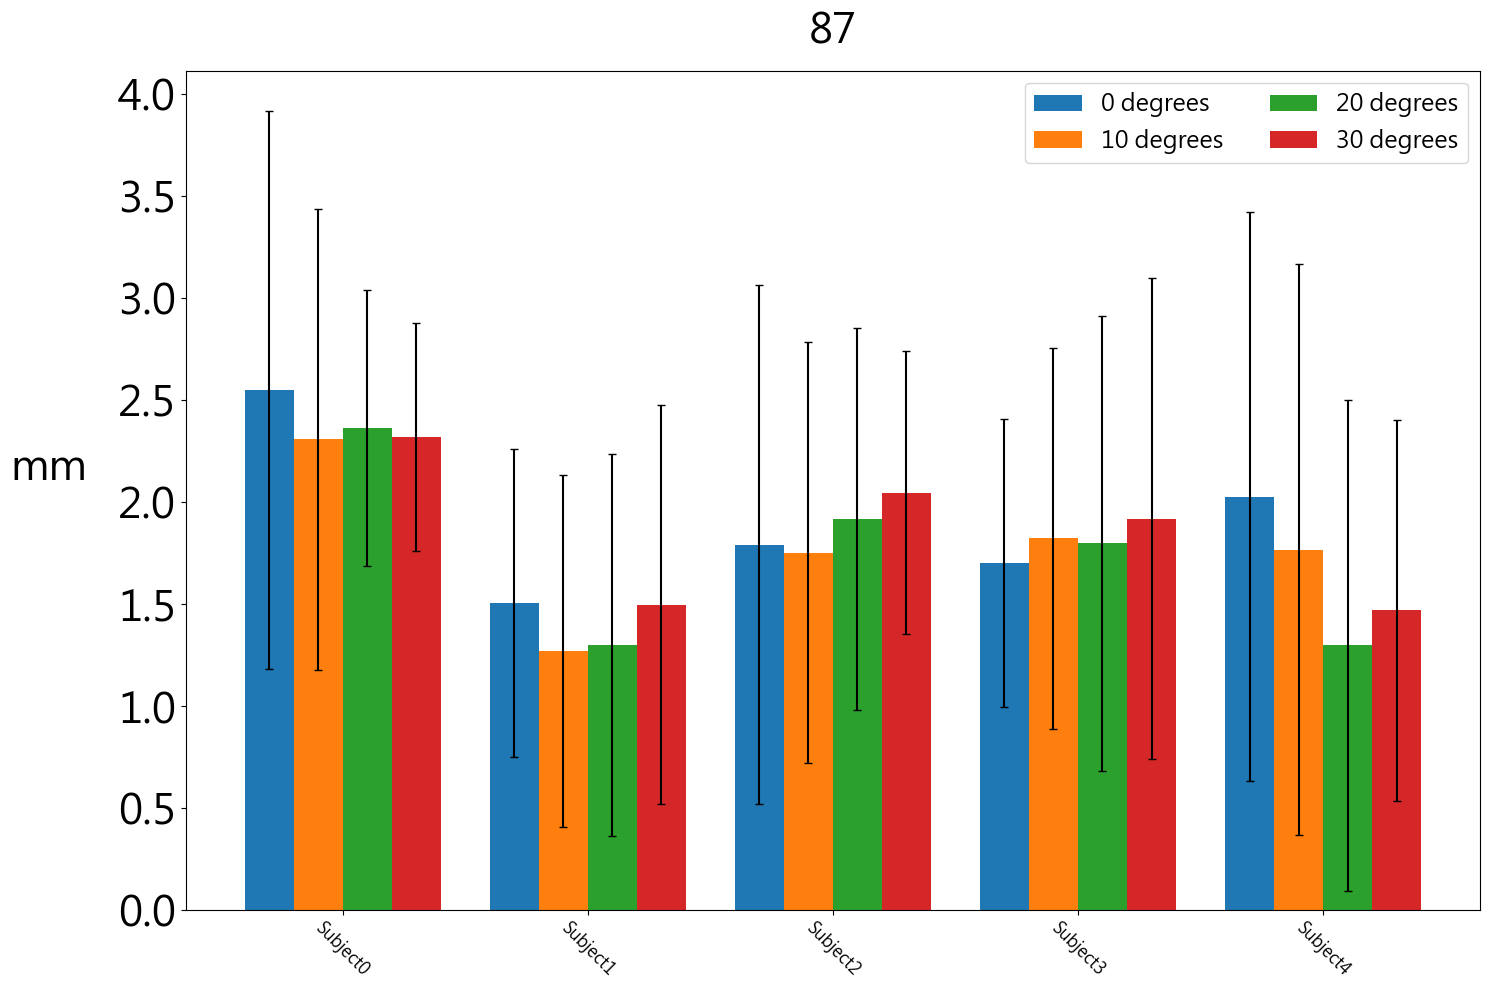

In [8]:
B = localization_error_Draw()

B.draw_each_acu_bars("87", B.all_err())
B.draw_each_subject_bars("87", B.all_err())

In [49]:
#     def each_acu_err(self):
#         result = {}
#         for ear_type in self.ear_types:
#             result[ear_type] = {}
            
            
#             for deg in self.degrees:
#                 result[ear_type][deg] = []

#                 for i in range(4):
#                     df = pd.DataFrame()
#                     names = os.listdir(os.path.join(self.occluded_result, ear_type))
#                     for name in names:
#                         indexes = os.listdir(os.path.join(self.occluded_result, ear_type, name, "error", deg))
#                         error_df = self.read_csv(os.path.join(self.occluded_result, ear_type, name, "error", deg, indexes[i], "error.csv"))
#                         df = pd.concat([df, error_df])                    



#                     df_np = df.to_numpy()

#                     result[ear_type][deg].append(df_np)
#         print(len(result))
#         print(len(result["free"]))
#         print(result["free"]['15cm_0mm_0deg'][0].shape)
#         return result
    
#     def draw_each_acu_bars(self, title, each_acu_err):
#         for ear_type in self.ear_types:
#             for deg in self.degrees:
                
#                 plt.figure(figsize=(15,10))
#                 for i in range(0, len(each_acu_err[ear_type][deg])): 
#                     means = np.nanmean(each_acu_err[ear_type][deg][i]*10, axis = 0)
#                     stds = np.nanstd(each_acu_err[ear_type][deg][i]*10, axis = 0)
#                     print(means.shape)
# #                     for j in range(0 ,len(each_acu_err[ear_type][deg][i])):
# #                         means = np.nanmean(each_acu_err[ear_type][deg][i][j]*10, axis = 0)
                        
# #                         stds = np.nanstd(each_acu_err[ear_type][deg][i][j]*10, axis = 0)
#                     plt.bar(np.arange(means.shape[0]) + i*0.2, means, yerr=stds, align='center', label = '{index} degrees'.format(index = 0 + 10*i), ecolor='black', capsize=3, width=0.2)


#                 plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

#                 plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

#                 font_path = r'C:\Windows\Fonts\msjhl.ttc'
#                 font = FontProperties(fname=font_path, size=12)
#                 plt.xticks(np.arange(len(means)) + 0.3, self.acupoints_name[:len(means)], fontsize=12, rotation=-45, ha='center')


#                 plt.yticks(fontsize=30)
#                 plt.title(title, fontsize = 30, pad = 20)

#                 plt.legend(fontsize=17, ncol = 2)

#                 plt.tight_layout()

#     #                 if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
#     #                     os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
#     #                 plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))

#                 plt.show()

#     def each_subject_err(self):
#         result = {}
#         for ear_type in self.ear_types:
#             result[ear_type] = {}
            
            
#             for deg in self.degrees:
#                 result[ear_type][deg] = {}
#                 result[ear_type][deg]["means"] = []
#                 result[ear_type][deg]["stds"] = []
#                 names = os.listdir(os.path.join(self.occluded_result, ear_type))
#                 for i in range(4):
#                     means = []
#                     stds = []
#                     for name in names:
#                         indexes = os.listdir(os.path.join(self.occluded_result, ear_type, name, "error", deg))
#                         error_np = self.read_csv(os.path.join(self.occluded_result, ear_type, name, "error", deg, indexes[i], "error.csv")).to_numpy()
#                         means.append(np.nanmean(error_np*10, axis = (0, 1)))
#                         stds.append(np.nanstd(error_np*10, axis = (0, 1)))                    



                    

#                     result[ear_type][deg]["means"].append(means)
#                     result[ear_type][deg]["stds"].append(stds)

#         return result 
        
        
        
#     def draw_each_subject_bars(self, title, each_subject_err):
#         for ear_type in self.ear_types:
#             for deg in self.degrees:
                
#                 plt.figure(figsize=(15,10))
#                 for i in range(0, len(each_subject_err[ear_type][deg]["means"])): 
# #                     means = np.nanmean(each_subject_err[ear_type][deg][i]*10, axis = (0,1))
# #                     print(means.shape)
# #                     stds = np.nanstd(each_subject_err[ear_type][deg][i]*10, axis = (0,1))
                    
# #                     for j in range(0 ,len(each_acu_err[ear_type][deg][i])):
# #                         means = np.nanmean(each_acu_err[ear_type][deg][i][j]*10, axis = 0)
                        
# #                         stds = np.nanstd(each_acu_err[ear_type][deg][i][j]*10, axis = 0)
#                     plt.bar(np.arange(len(each_subject_err[ear_type][deg]["means"][i])) + i*0.2, each_subject_err[ear_type][deg]["means"][i], yerr=each_subject_err[ear_type][deg]["stds"][i], align='center', label = '{index} degrees'.format(index = 0 + 10*i), ecolor='black', capsize=3, width=0.2)


#                 plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

#                 plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

#                 font_path = r'C:\Windows\Fonts\msjhl.ttc'
#                 font = FontProperties(fname=font_path, size=12)
#                 plt.xticks(np.arange(len(each_subject_err[ear_type][deg]["means"][0])) + 0.3, ["Subject"+str(x) for x in list(range(0 , len(each_subject_err[ear_type][deg]["means"][0])))], fontsize=12, rotation=-45, ha='center')


#                 plt.yticks(fontsize=30)
#                 plt.title(title, fontsize = 30, pad = 20)

#                 plt.legend(fontsize=17, ncol = 2)

#                 plt.tight_layout()

#     #                 if not os.path.isdir(os.path.join(traditional_inpainting, ear_type, "figure", deg)):
#     #                     os.makedirs(os.path.join(traditional_inpainting, ear_type, "figure", deg))
#     #                 plt.savefig(os.path.join(traditional_inpainting, ear_type, "figure", deg,'different acupoints.png').format(index = 0))

#                 plt.show()
#     def total_err(self):
#         result = {}
#         for ear_type in self.ear_types:
#             result[ear_type] = {}
#             df = pd.DataFrame()
#             names = os.listdir(os.path.join(self.occluded_result, ear_type))
#             for name in names:
#                 for deg in self.degrees:
#                     indexes = os.listdir(os.path.join(self.occluded_result, ear_type, name, "error", deg))
#                     for index in indexes:
#                         error_df = self.read_csv(os.path.join(self.occluded_result, ear_type, name, "error", deg, index, "error.csv"))
#                         df = pd.concat([df, error_df])

#             result[ear_type] = df
                    

                    

#         return result 
        
#     def draw_total_bars(self, title, total_err):
#         plt.figure(figsize=(15,10))
        
#         means = []
#         stds = []
#         for ear_type in self.ear_types:
#             means.append(np.nanmean(total_err[ear_type], axis = (0,1))*10)
#             stds.append(np.nanstd(total_err[ear_type], axis = (0,1))*10)
#         print(means)
#         print(stds)

#         plt.bar(np.arange(len(self.ear_types)), means, yerr=stds, align='center', label = ear_type, ecolor='black', capsize=3, width=0.2)

#         plt.ylabel('mm' , fontsize = 30, labelpad = 50, rotation = 0)

#         plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 

#         font_path = r'C:\Windows\Fonts\msjhl.ttc'
#         font = FontProperties(fname=font_path, size=12)
#         plt.xticks(np.arange(len(self.ear_types)), self.ear_types, fontsize=12, rotation=-45, ha='center')


#         plt.yticks(fontsize=30)
#         plt.title(title, fontsize = 30, pad = 20)

# #         plt.legend(fontsize=17, ncol = 2)

#         plt.tight_layout()

# #         if not os.path.isdir(os.path.join("..", "figure", "occlusion")):
# #             os.makedirs(os.path.join("..", "figure", "occlusion"))
# #         plt.savefig(os.path.join("..", "figure", "occlusion",'total_average.png').format(index = 0))

#         plt.show()

(1516, 21)
(1798, 21)
(1195, 21)
(1190, 21)
(1359, 21)
(1959, 21)
(1351, 21)
(1211, 21)
(11579, 21)
(1495, 14)
(1923, 14)
(1535, 14)
(1037, 14)
(1908, 14)
(7898, 14)


ValueError: axes don't match array